# Importing necessary packages and datasets

In [2]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, roc_auc_score, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.feature_selection import RFE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import optuna
import seaborn as sns


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


As explained in our resampling process, we import the datasets individually according to their non-SMOTEd and SMOTEd datasets, allowing for possible 5-fold cross validation

In [3]:
fold1 = pd.read_csv('./smote_train_data/fold_1.csv')
fold2 = pd.read_csv('./smote_train_data/fold_2.csv')
fold3 = pd.read_csv('./smote_train_data/fold_3.csv')
fold4 = pd.read_csv('./smote_train_data/fold_4.csv')
fold5 = pd.read_csv('./smote_train_data/fold_5.csv')

smote_fold_1 = pd.read_csv('./smote_train_data/smote_fold_1.csv')
smote_fold_2 = pd.read_csv('./smote_train_data/smote_fold_2.csv')
smote_fold_3 = pd.read_csv('./smote_train_data/smote_fold_3.csv')
smote_fold_4 = pd.read_csv('./smote_train_data/smote_fold_4.csv')
smote_fold_5 = pd.read_csv('./smote_train_data/smote_fold_5.csv')

# Base SVM Model

Here, we try building a base SVM model with the given dataset first. We utilise SMOTEd folds 1 to 4 to make up the training data, and non-SMOTEd fold 5 as the validation data.

In [4]:
train_data = pd.concat([smote_fold_1, smote_fold_2, smote_fold_3, smote_fold_4])
val_data = fold5

display(train_data)
display(val_data)

,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True,fraud_status
0,1985,2,5,0,0,1,0,0,0,0,...,0.0,12.000000,0.0,0.000000,2.000000,8.000000,6.000000,14.000000,0.000000,0.0
1,1996,12,31,0,0,0,0,0,0,0,...,0.0,53.000000,0.0,10.000000,3.000000,32.000000,34.000000,66.000000,0.000000,0.0
2,1999,9,8,1,0,0,0,0,0,0,...,0.0,19.000000,0.0,14.000000,1.000000,34.000000,0.000000,34.000000,0.000000,0.0
3,2016,4,25,0,0,0,0,0,0,0,...,0.0,0.000000,0.0,0.000000,6.000000,6.000000,0.000000,6.000000,0.000000,0.0
4,2008,11,22,1,0,0,0,0,0,0,...,0.0,7.000000,0.0,7.000000,16.000000,30.000000,0.000000,30.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40951,2001,5,7,0,0,1,0,0,0,0,...,0.0,29.051793,0.0,10.115537,15.111554,34.665339,19.613545,54.223107,0.055777,1.0
40952,2005,5,11,0,0,0,0,0,0,0,...,0.0,20.270349,0.0,9.719186,26.188954,34.367442,21.811046,56.178488,0.000000,1.0
40953,1984,11,21,0,0,0,0,0,0,0,...,0.0,21.886777,0.0,9.000000,0.238548,31.125325,0.000000,31.125325,0.000000,1.0
40954,2010,6,21,0,0,0,0,0,0,0,...,0.0,12.700108,0.0,8.288482,14.288482,17.638536,17.638536,35.019376,0.257696,1.0


,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True,fraud_status
0,1989,12,29,0,0,0,0,0,0,0,...,0.0,22.0,0.0,5.0,13.0,40.0,0.0,40.0,0.0,0.0
1,1984,11,12,0,0,1,0,0,0,0,...,0.0,52.0,0.0,11.0,3.0,35.0,31.0,66.0,0.0,1.0
2,2010,5,5,1,0,0,0,0,0,0,...,0.0,22.0,0.0,7.0,0.0,17.0,12.0,28.0,1.0,0.0
3,1998,6,23,1,0,0,0,0,0,0,...,0.0,1.0,0.0,1.0,1.0,3.0,0.0,3.0,0.0,0.0
4,1999,12,22,0,0,0,0,0,0,0,...,0.0,38.0,0.0,17.0,1.0,34.0,22.0,56.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21673,2007,9,6,0,0,0,0,0,0,0,...,0.0,12.0,0.0,11.0,12.0,35.0,0.0,35.0,0.0,0.0
21674,2012,10,13,0,0,0,0,0,0,0,...,0.0,0.0,0.0,0.0,4.0,4.0,0.0,4.0,0.0,0.0
21675,2018,11,10,0,0,1,0,0,0,0,...,0.0,1.0,0.0,0.0,2.0,3.0,0.0,3.0,0.0,0.0
21676,2010,1,8,0,0,0,0,0,1,0,...,0.0,5.0,0.0,0.0,0.0,3.0,2.0,5.0,0.0,0.0


## Feature scaling of numerical data

Feature scaling is key especially to SVM models, which utilises distance between data points and decision boundary to determine the hyperplane's position. If features are not scaled, those with larger ranges will dominate the distance calculations, leading to skewed or suboptimal hyperplanes. We perform feature scaling on the numerical features.

In [5]:
numerical_features = train_data.drop(columns=['fraud_status', 'region_101',
                   'region_103', 'region_104', 'region_105', 'region_106', 'region_107',
                   'region_199', 'region_206', 'region_301', 'region_302', 'region_303',
                   'region_304', 'region_305', 'region_306', 'region_307', 'region_308',
                   'region_309', 'region_310', 'region_311', 'region_312', 'region_313',
                   'region_371', 'region_372', 'region_379', 'region_399', 'district_62',
                   'district_63', 'district_69', 'client_catg_11', 'client_catg_12', 'client_catg_51'
                   ]).columns

numerical_features = list(numerical_features)

print(numerical_features)

['creation_year', 'creation_month', 'creation_day', 'consumption_level_1_mean', 'consumption_level_1_std', 'consumption_level_1_min', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_mean', 'consumption_level_2_std', 'consumption_level_2_min', 'consumption_level_2_max', 'consumption_level_2_median', 'consumption_level_2_sum', 'consumption_level_3_mean', 'consumption_level_3_min', 'consumption_level_3_max', 'consumption_level_3_sum', 'consumption_level_4_mean', 'consumption_level_4_min', 'consumption_level_4_max', 'consumption_level_4_median', 'consumption_level_4_sum', 'old_index_mean', 'old_index_min', 'old_index_max', 'old_index_median', 'diff_in_index_mean', 'diff_in_index_std', 'diff_in_index_min', 'diff_in_index_max', 'diff_in_index_sum', 'total_consumption_mean', 'total_consumption_std', 'total_consumption_min', 'total_consumption_max', 'total_consumption_sum', 'months_number_min', 'months_number_max', 'months_number_median', 'meter_number_count', 'meter

We first fit the scaler to the numerical features of the train data and perform scaling.

In [5]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler with the training data and scale the data.
train_data_scaled = train_data.copy()
train_data_scaled[numerical_features] = scaler.fit_transform(train_data_scaled[numerical_features])

# Display the scaled data
display(train_data_scaled)

,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True,fraud_status
0,-1.455290,-1.571095,-1.545187,0,0,1,0,0,0,0,...,-0.002471,-0.452078,-0.03849,-1.206243,-0.888334,-1.160868,-0.462351,-0.961610,-0.077868,0.0
1,-0.436198,1.519945,1.699035,0,0,0,0,0,0,0,...,-0.002471,2.007816,-0.03849,0.382250,-0.804254,0.318692,1.423188,0.994903,-0.077868,0.0
2,-0.158263,0.592633,-1.170854,1,0,0,0,0,0,0,...,-0.002471,-0.032096,-0.03849,1.017647,-0.972415,0.441989,-0.866395,-0.209105,-0.077868,0.0
3,1.416698,-0.952887,0.950368,0,0,0,0,0,0,0,...,-0.002471,-1.172047,-0.03849,-1.206243,-0.552011,-1.284165,-0.866395,-1.262612,-0.077868,0.0
4,0.675540,1.210841,0.576035,1,0,0,0,0,0,0,...,-0.002471,-0.752065,-0.03849,-0.094298,0.288798,0.195396,-0.866395,-0.359606,-0.077868,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
40951,0.027026,-0.643783,-1.295632,0,0,1,0,0,0,0,...,-0.002471,0.570986,-0.03849,0.400603,0.214096,0.483006,0.454394,0.551794,-0.046568,1.0
40952,0.397606,-0.643783,-0.796520,0,0,0,0,0,0,0,...,-0.002471,0.044122,-0.03849,0.337643,1.145494,0.464641,0.602376,0.625366,-0.077868,1.0
40953,-1.547935,1.210841,0.451257,0,0,0,0,0,0,0,...,-0.002471,0.141103,-0.03849,0.223401,-1.036439,0.264770,-0.866395,-0.317265,-0.077868,1.0
40954,0.860829,-0.334679,0.451257,0,0,0,0,0,0,0,...,-0.002471,-0.410073,-0.03849,0.110377,0.144892,-0.566668,0.321396,-0.170751,0.066744,1.0


After which, we use the scalar as defined before to transform the validation data.

In [6]:
# Transform the validation data with the scaler
val_data_scaled = val_data.copy()
val_data_scaled[numerical_features] = scaler.transform(val_data_scaled[numerical_features])

# Display the scaled data
display(val_data_scaled)

,creation_year,creation_month,creation_day,region_101,region_103,region_104,region_105,region_106,region_107,region_199,...,meter_coefficient_50,reading_remark_6,reading_remark_7,reading_remark_8,reading_remark_9,meter_type_0,meter_type_1,is_index_discrepancy_False,is_index_discrepancy_True,fraud_status
0,-1.084711,1.519945,1.449480,0,0,0,0,0,0,0,...,-0.002471,0.147896,-0.03849,-0.411996,0.036555,0.811879,-0.866395,0.016647,-0.077868,0.0
1,-1.547935,1.210841,-0.671743,0,0,1,0,0,0,0,...,-0.002471,1.947819,-0.03849,0.541099,-0.804254,0.503637,1.221166,0.994903,-0.077868,1.0
2,0.860829,-0.643783,-1.545187,1,0,0,0,0,0,0,...,-0.002471,0.147896,-0.03849,-0.094298,-1.056496,-0.606033,-0.058307,-0.434856,0.483305,0.0
3,-0.250908,-0.334679,0.700813,1,0,0,0,0,0,0,...,-0.002471,-1.112049,-0.03849,-1.047394,-0.972415,-1.469110,-0.866395,-1.375487,-0.077868,0.0
4,-0.158263,1.519945,0.576035,0,0,0,0,0,0,0,...,-0.002471,1.107855,-0.03849,1.494195,-0.972415,0.441989,0.615100,0.618650,-0.077868,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21673,0.582895,0.592633,-1.420409,0,0,0,0,0,0,0,...,-0.002471,-0.452078,-0.03849,0.541099,-0.047526,0.503637,-0.866395,-0.171480,-0.077868,0.0
21674,1.046119,0.901737,-0.546965,0,0,0,0,0,0,0,...,-0.002471,-1.172047,-0.03849,-1.206243,-0.720173,-1.407462,-0.866395,-1.337862,-0.077868,0.0
21675,1.601988,1.210841,-0.921298,0,0,1,0,0,0,0,...,-0.002471,-1.112049,-0.03849,-1.206243,-0.888334,-1.469110,-0.866395,-1.375487,-0.077868,0.0
21676,0.860829,-1.880199,-1.170854,0,0,0,0,0,1,0,...,-0.002471,-0.872060,-0.03849,-1.206243,-1.056496,-1.469110,-0.731714,-1.300237,-0.077868,0.0


## Building the base SVM model

Now, we begin our model building process. As we experiment in this initial process, we will focus on f1-score of the fraud class, since there are downsides to both false positives and false negatives. While recall is more important than precision due to the greater severity in false negatives which is costly for the company, it is important to also minimise false positives as performing investigations on regular customers will incur cost and potentially affect consumer-supplier relations.

Firstly, we split our train and validation datasets into their features (X) and target variable (Y).

In [7]:
X_train = train_data_scaled.drop(columns=['fraud_status'])
y_train = train_data_scaled['fraud_status']

X_val = val_data_scaled.drop(columns=['fraud_status'])
y_val = val_data_scaled['fraud_status']

We created our base SVM model using a Radial Basis Function (RBF) kernel as it can model non-linear relationships between features. Mapping data into higher-dimensional spaces, it allows for separation of classes that are not linearly separable.

Looking at the classificaiton report of the base model, we notice that the model performs extremely well in predicting the majority class, with high evaluation scores for non-frauds. However, it performs poorly in predicting frauds. The f1-score for fraud class is 0.26. The accuracy is very high at 0.94, but this is attributed to the imbalance in classes for the validation dataset.

In [49]:
# Initialize an SVM model with default hyperparameters
svm_model = SVC(kernel='rbf', class_weight='balanced', random_state=42)

# Fit the model
svm_model.fit(X_train, y_train)

# Predict the validation data
val_predictions = svm_model.predict(X_val)

# Print the classification report
print("Validation data classification report: ")
print(classification_report(y_val, val_predictions))

Validation data classification report: 
              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     20478
         1.0       0.36      0.20      0.26      1200

    accuracy                           0.94     21678
   macro avg       0.66      0.59      0.61     21678
weighted avg       0.92      0.94      0.93     21678



In [50]:
# Plot confusion matrix
print("Confusion matrix: ")
print(confusion_matrix(y_val, val_predictions))

Confusion matrix: 
[[20063   415]
 [  963   237]]


Our ROC-AUC Score however, is pretty decent at 0.80. It achieves a decent trade-off between minimizing false positives and false negatives across thresholds.

In [51]:
# Calculate and display ROC-AUC score
val_probabilities = svm_model.decision_function(X_val)
roc_auc = roc_auc_score(y_val, val_probabilities)

print("ROC-AUC score: ")
print(roc_auc)

ROC-AUC score: 
0.8018973207018916


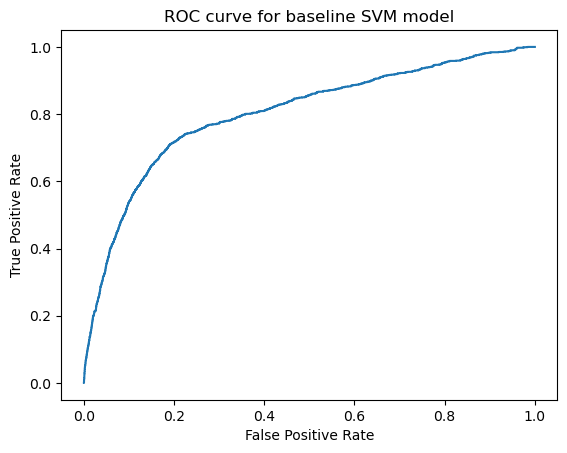

In [54]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_val, val_probabilities)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for baseline SVM model')
plt.show()

## Base model with PCA

As our initial base model comprised of all 102 features, thers is a possibility of curse of dimensionality. Hence, we experiment with PCA to consider if training an SVM model with principle components might be more meaningful at separating the classes.

In [55]:
# Initialize the PCA
pca = PCA(random_state=42)

# Fit the PCA with the training data
pca.fit(X_train)

PCA(random_state=42)

Plotting the graph of Cumulative explained variance against no. of components, we observe that the cumulative explained variance of appears to increase steadily from 0.6 to 0.9. 40 components make up 95% of the variance, which is a big drop compared to the original 102 features. We then transform our train and validation features according to these principal components.

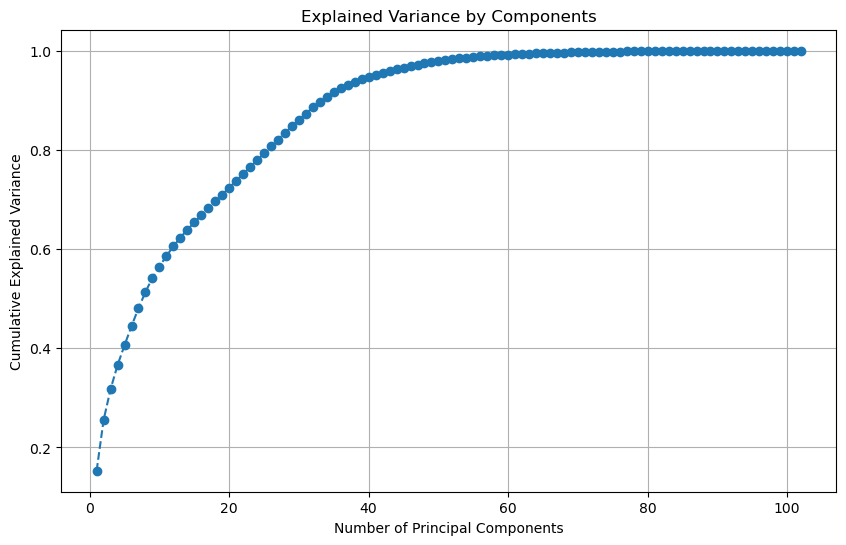

In [56]:
# Get explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_explained_variance = explained_variance_ratio.cumsum()

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.show()

In [57]:
# Select the number of components that explain 95% of the variance
n_components = len(cumulative_explained_variance[cumulative_explained_variance < 0.95])
print("Number of components: ")
print(n_components)

# Fit PCA with the optimal number of components
pca_optimal = PCA(n_components=n_components, random_state=42)
X_train_reduced = pca_optimal.fit_transform(X_train)
X_val_reduced = pca_optimal.transform(X_val)

Number of components: 
40


After which, we retrain our base model again using the new reduced train datasets, and validating it against the reduced validation dataset as well.

In [58]:
# Train the SVM model with the reduced data
svm_model_reduced = SVC(kernel='rbf', class_weight='balanced', random_state=42)
svm_model_reduced.fit(X_train_reduced, y_train)

SVC(class_weight='balanced', random_state=42)

The recall of fraud class has risen drastically, but at the expense of precision for the fraud class. Here, we observe the precision recall trade-off firsthand. There is also a drop in accuracy and there are many more false positives. However, f1-score of the fraud class did not really improve.

In [59]:
# Predict the validation data
val_predictions_reduced = svm_model_reduced.predict(X_val_reduced)

# Print the classification report
print("Validation data classification report (PCA): ")
print(classification_report(y_val, val_predictions_reduced))

Validation data classification report (PCA): 
              precision    recall  f1-score   support

         0.0       0.97      0.82      0.89     20478
         1.0       0.17      0.63      0.27      1200

    accuracy                           0.81     21678
   macro avg       0.57      0.73      0.58     21678
weighted avg       0.93      0.81      0.85     21678



In [60]:
# Plot confusion matrix
print("Confusion matrix (PCA): ")
print(confusion_matrix(y_val, val_predictions_reduced))

Confusion matrix (PCA): 
[[16717  3761]
 [  439   761]]


Our ROC-AUC score is observed to be approximately the same as before.

In [61]:
# Calculate and display ROC-AUC score
val_probabilities_reduced = svm_model_reduced.decision_function(X_val_reduced)
roc_auc = roc_auc_score(y_val, val_probabilities_reduced)

print("ROC-AUC score: ")
print(roc_auc)

ROC-AUC score: 
0.8017220309600548


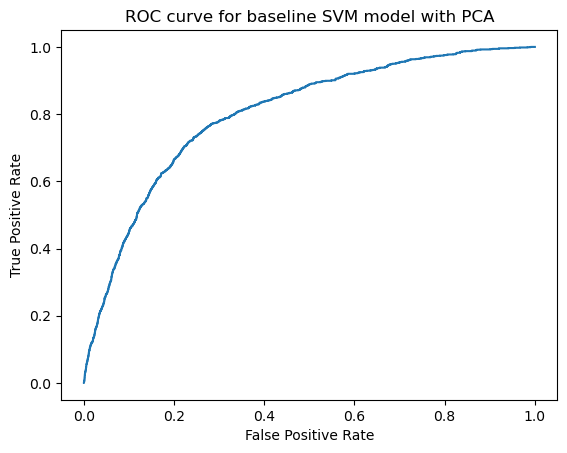

In [62]:
# Plot the ROC curve
fpr, tpr, _ = roc_curve(y_val, val_probabilities_reduced)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for baseline SVM model with PCA')
plt.show()

# Model Improvements

After experimenting with a base model and PCA, we move onto explore other methods of model improvement.

We tried two things in order:
1. Feature Selection
- LightGBM Feature Importance Test
- Recursive Feature Elimination (RFE) using LightGBM and 5-fold cross validation.
2. After selecting n best features, we conducted hyperparameter tuning with 5-fold cross validation.

We used optuna to streamline our process of doing these checks to reduce total computational time and maximise efficiency.

Firstly, we conduct Feature Selection. THis is important in reducing the dimensionality of the dataset by identifying and retaining the most relevant features for the task, reducing risk of noise, improve model interpretability, and reduce overfitting. This is especially so for SVM that is sensitive to irrelevant features.

# LightGBM Feature importance test

LightGBM is a gradient-boosting framework that provides a feature importance score for each feature, based on its contribution to the model's predictive performance. In this run, we utilise the defined train & validation data from before, with scaled smote_fold 1 to 4 as train data and scaled fold 5 as the test data. We use LGBM because its tree structure evaluates feature splits and their contributions to reducing error, and for its methods of leaf-wise tree growth. This allows it to grow deeper trees selectively and reduces computational time significantly, which is more suited for our large dataset and high dimensional feature space.

In [ ]:

def perform_feature_importance_selection(X_train, y_train, trial_number):
    # Train LightGBM on all features
    print(f"[Trial {trial_number}] Training LightGBM on all features for importance ranking...")
    lgbm = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1, verbose=-1)
    lgbm.fit(X_train, y_train)

    # Get feature importance and rank features
    feature_importance = pd.DataFrame({
        'feature': X_train.columns,
        'importance': lgbm.feature_importances_
    }).sort_values(by='importance', ascending=False)

    return feature_importance


In [20]:

def objective(trial):
    # Get `k` from the trial
    k = trial.suggest_int('k', 1, X_train.shape[1], step=2)
    print(f"\n[Trial {trial.number}] Evaluating Top {k} Features...")

    # Get feature importance and select top `k` features
    feature_importance = perform_feature_importance_selection(X_train, y_train, trial.number)
    selected_features = feature_importance['feature'].iloc[:k].tolist()
    print(f"[Trial {trial.number}] Selected Features: {selected_features}")

    # Subset the dataset
    X_train_reduced = X_train[selected_features]
    X_val_reduced = X_val[selected_features]

    # Train LightGBM on reduced dataset
    print(f"[Trial {trial.number}] Training LightGBM on Top {k} Features...")
    lgbm = LGBMClassifier(random_state=42, class_weight='balanced', n_jobs=-1, verbose=-1)
    lgbm.fit(X_train_reduced, y_train)

    # Evaluate on validation set
    print(f"[Trial {trial.number}] Evaluating on validation set...")
    val_predictions = lgbm.predict(X_val_reduced)
    f1 = f1_score(y_val, val_predictions, pos_label=1.0)
    print(f"[Trial {trial.number}] F1-Score with Top {k} Features: {f1:.4f}")

    # Print Classification Report
    print(f"[Trial {trial.number}] Classification Report:\n")
    print(classification_report(y_val, val_predictions))

    # Log selected features for this trial
    trial.set_user_attr("selected_features", selected_features)

    return f1



In [21]:

# Define the search space for `k`
search_space = {'k': list(range(1, X_train.shape[1] + 1, 2))}  # Step size = 2

# Use GridSampler for deterministic search
sampler = optuna.samplers.GridSampler(search_space)
study = optuna.create_study(direction='maximize', sampler=sampler, study_name='feature_importance_study')


[I 2024-11-30 02:09:25,776] A new study created in memory with name: feature_importance_study


In [22]:

# Run the study (n_jobs allows parallel trials)
study.optimize(objective, n_jobs=5)

# Print the best result
print("\nBest result:")
print(f"Optimal number of features: {study.best_params['k']}")
print(f"Best F1-Score: {study.best_value:.4f}")
print(f"Selected Features: {study.best_trial.user_attrs['selected_features']}")

/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It wil


[Trial 0] Evaluating Top 59 Features...
[Trial 0] Training LightGBM on all features for importance ranking...

[Trial 1] Evaluating Top 23 Features...
[Trial 1] Training LightGBM on all features for importance ranking...

[Trial 2] Evaluating Top 21 Features...
[Trial 2] Training LightGBM on all features for importance ranking...

[Trial 3] Evaluating Top 45 Features...
[Trial 3] Training LightGBM on all features for importance ranking...

[Trial 4] Evaluating Top 5 Features...
[Trial 4] Training LightGBM on all features for importance ranking...
[Trial 3] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6', 'consumption

[I 2024-11-30 02:09:35,959] Trial 4 finished with value: 0.016142050040355124 and parameters: {'k': 5}. Best is trial 4 with value: 0.016142050040355124.


[Trial 4] Evaluating on validation set...
[Trial 4] F1-Score with Top 5 Features: 0.0161
[Trial 4] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     20478
         1.0       0.26      0.01      0.02      1200

    accuracy                           0.94     21678
   macro avg       0.60      0.50      0.49     21678
weighted avg       0.91      0.94      0.92     21678


[Trial 5] Evaluating Top 57 Features...
[Trial 5] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:09:36,410] Trial 1 finished with value: 0.15807560137457044 and parameters: {'k': 23}. Best is trial 1 with value: 0.15807560137457044.
/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:09:36,420] Trial 2 finished with value: 0.15912208504801098 and parameters: {'k': 21}. Best is trial 2 with value: 0.15912208504801098.


[Trial 2] Evaluating on validation set...
[Trial 1] Evaluating on validation set...
[Trial 1] F1-Score with Top 23 Features: 0.1581
[Trial 1] Classification Report:

[Trial 2] F1-Score with Top 21 Features: 0.1591
[Trial 2] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.45      0.10      0.16      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.54      0.56     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 6] Evaluating Top 91 Features...
[Trial 6] Training LightGBM on all features for importance ranking...
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.45      0.10      0.16      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.54      0.56     21678
weighted avg       0.92      0.94      0.9

/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:09:37,067] Trial 3 finished with value: 0.19223173140223832 and parameters: {'k': 45}. Best is trial 3 with value: 0.19223173140223832.


[Trial 3] Evaluating on validation set...
[Trial 3] F1-Score with Top 45 Features: 0.1922
[Trial 3] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.46      0.12      0.19      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.56      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 8] Evaluating Top 53 Features...
[Trial 8] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:09:37,366] Trial 0 finished with value: 0.1629327902240326 and parameters: {'k': 59}. Best is trial 3 with value: 0.19223173140223832.


[Trial 0] Evaluating on validation set...
[Trial 0] F1-Score with Top 59 Features: 0.1629
[Trial 0] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.44      0.10      0.16      1200

    accuracy                           0.94     21678
   macro avg       0.69      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 9] Evaluating Top 9 Features...
[Trial 9] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(


[Trial 5] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6', 'consumption_level_2_mean', 'meter_type_1', 'time_since_last_invoice_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_1_max', 'consumption_level_1_mean', 'is_index_discrepancy_True', 'meter_type_0', 'consumption_level_4_mean', 'region_104', 'diff_in_index_sum', 'region_301', 'time_since_last_invoice_max', 'region_103', 'creation_day', 'total_consumption_sum', 'consumption_level_1_std', 'creation_month', 'consumption_level_2_sum', 'region_105', 'region_312', 'region_306', 'diff_in_index_mean', 'region_309', 'region_107', 'consump

[I 2024-11-30 02:09:45,940] Trial 9 finished with value: 0.05500381970970206 and parameters: {'k': 9}. Best is trial 3 with value: 0.19223173140223832.


[Trial 9] Evaluating on validation set...
[Trial 9] F1-Score with Top 9 Features: 0.0550
[Trial 9] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     20478
         1.0       0.33      0.03      0.06      1200

    accuracy                           0.94     21678
   macro avg       0.64      0.51      0.51     21678
weighted avg       0.91      0.94      0.92     21678


[Trial 10] Evaluating Top 67 Features...
[Trial 10] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:09:46,667] Trial 8 finished with value: 0.1732706514439221 and parameters: {'k': 53}. Best is trial 3 with value: 0.19223173140223832.
/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:09:46,700] Trial 6 finished with value: 0.1800818553888131 and parameters: {'k': 91}. Best is trial 3 with value: 0.19223173140223832.


[Trial 8] Evaluating on validation set...
[Trial 6] Evaluating on validation set...
[Trial 8] F1-Score with Top 53 Features: 0.1733
[Trial 8] Classification Report:

[Trial 6] F1-Score with Top 91 Features: 0.1801
[Trial 6] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.45      0.11      0.17      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 11] Evaluating Top 83 Features...
[Trial 11] Training LightGBM on all features for importance ranking...
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.50      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.58     21678
weighted avg       0.92      0.94      0

/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:09:48,144] Trial 5 finished with value: 0.168135593220339 and parameters: {'k': 57}. Best is trial 3 with value: 0.19223173140223832.


[Trial 5] Evaluating on validation set...
[Trial 5] F1-Score with Top 57 Features: 0.1681
[Trial 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.45      0.10      0.17      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 13] Evaluating Top 71 Features...
[Trial 13] Training LightGBM on all features for importance ranking...
[Trial 7] Evaluating on validation set...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:09:48,350] Trial 7 finished with value: 0.15955983493810177 and parameters: {'k': 65}. Best is trial 3 with value: 0.19223173140223832.


[Trial 7] F1-Score with Top 65 Features: 0.1596
[Trial 7] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.46      0.10      0.16      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.54      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 14] Evaluating Top 69 Features...
[Trial 14] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(


[Trial 10] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6', 'consumption_level_2_mean', 'meter_type_1', 'time_since_last_invoice_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_1_max', 'consumption_level_1_mean', 'is_index_discrepancy_True', 'meter_type_0', 'consumption_level_4_mean', 'region_104', 'diff_in_index_sum', 'region_301', 'time_since_last_invoice_max', 'region_103', 'creation_day', 'total_consumption_sum', 'consumption_level_1_std', 'creation_month', 'consumption_level_2_sum', 'region_105', 'region_312', 'region_306', 'diff_in_index_mean', 'region_309', 'region_107', 'consum

[I 2024-11-30 02:09:56,862] Trial 10 finished with value: 0.17598908594815826 and parameters: {'k': 67}. Best is trial 3 with value: 0.19223173140223832.


[Trial 10] Evaluating on validation set...
[Trial 10] F1-Score with Top 67 Features: 0.1760
[Trial 10] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.48      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 15] Evaluating Top 15 Features...
[Trial 15] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:09:57,526] Trial 12 finished with value: 0.17532029669588672 and parameters: {'k': 55}. Best is trial 3 with value: 0.19223173140223832.


[Trial 12] Evaluating on validation set...
[Trial 12] F1-Score with Top 55 Features: 0.1753
[Trial 12] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.46      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 16] Evaluating Top 29 Features...
[Trial 16] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:09:57,805] Trial 11 finished with value: 0.1800818553888131 and parameters: {'k': 83}. Best is trial 3 with value: 0.19223173140223832.


[Trial 11] Evaluating on validation set...
[Trial 11] F1-Score with Top 83 Features: 0.1801
[Trial 11] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.50      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 17] Evaluating Top 93 Features...
[Trial 17] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:09:59,206] Trial 14 finished with value: 0.16928327645051194 and parameters: {'k': 69}. Best is trial 3 with value: 0.19223173140223832.


[Trial 14] Evaluating on validation set...
[Trial 14] F1-Score with Top 69 Features: 0.1693
[Trial 14] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.47      0.10      0.17      1200

    accuracy                           0.94     21678
   macro avg       0.71      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 18] Evaluating Top 37 Features...
[Trial 18] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:00,930] Trial 13 finished with value: 0.1702127659574468 and parameters: {'k': 71}. Best is trial 3 with value: 0.19223173140223832.


[Trial 13] Evaluating on validation set...
[Trial 13] F1-Score with Top 71 Features: 0.1702
[Trial 13] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.48      0.10      0.17      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 19] Evaluating Top 97 Features...
[Trial 19] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(


[Trial 15] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median']
[Trial 15] Training LightGBM on Top 15 Features...
[Trial 16] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6', 'consumption_level_2_mean', 'meter_type_1', 'time_since_last_invoice_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_1_max', 'co

[I 2024-11-30 02:10:07,364] Trial 15 finished with value: 0.1394395078605605 and parameters: {'k': 15}. Best is trial 3 with value: 0.19223173140223832.


[Trial 15] Evaluating on validation set...
[Trial 15] F1-Score with Top 15 Features: 0.1394
[Trial 15] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.39      0.09      0.14      1200

    accuracy                           0.94     21678
   macro avg       0.67      0.54      0.55     21678
weighted avg       0.92      0.94      0.92     21678


[Trial 20] Evaluating Top 85 Features...
[Trial 20] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:08,056] Trial 16 finished with value: 0.1748107364074329 and parameters: {'k': 29}. Best is trial 3 with value: 0.19223173140223832.


[Trial 16] Evaluating on validation set...
[Trial 16] F1-Score with Top 29 Features: 0.1748
[Trial 16] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.50      0.11      0.17      1200

    accuracy                           0.94     21678
   macro avg       0.73      0.55      0.57     21678
weighted avg       0.93      0.94      0.93     21678


[Trial 21] Evaluating Top 31 Features...
[Trial 21] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:08,808] Trial 17 finished with value: 0.1800818553888131 and parameters: {'k': 93}. Best is trial 3 with value: 0.19223173140223832.


[Trial 17] Evaluating on validation set...
[Trial 17] F1-Score with Top 93 Features: 0.1801
[Trial 17] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.50      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 22] Evaluating Top 63 Features...
[Trial 22] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:09,955] Trial 18 finished with value: 0.18229854689564068 and parameters: {'k': 37}. Best is trial 3 with value: 0.19223173140223832.


[Trial 18] Evaluating on validation set...
[Trial 18] F1-Score with Top 37 Features: 0.1823
[Trial 18] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.44      0.12      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.69      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 23] Evaluating Top 61 Features...
[Trial 23] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:11,856] Trial 19 finished with value: 0.16175462645647704 and parameters: {'k': 97}. Best is trial 3 with value: 0.19223173140223832.


[Trial 19] Evaluating on validation set...
[Trial 19] F1-Score with Top 97 Features: 0.1618
[Trial 19] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.46      0.10      0.16      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 24] Evaluating Top 33 Features...
[Trial 24] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(


[Trial 20] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6', 'consumption_level_2_mean', 'meter_type_1', 'time_since_last_invoice_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_1_max', 'consumption_level_1_mean', 'is_index_discrepancy_True', 'meter_type_0', 'consumption_level_4_mean', 'region_104', 'diff_in_index_sum', 'region_301', 'time_since_last_invoice_max', 'region_103', 'creation_day', 'total_consumption_sum', 'consumption_level_1_std', 'creation_month', 'consumption_level_2_sum', 'region_105', 'region_312', 'region_306', 'diff_in_index_mean', 'region_309', 'region_107', 'consum

[I 2024-11-30 02:10:18,517] Trial 20 finished with value: 0.1800818553888131 and parameters: {'k': 85}. Best is trial 3 with value: 0.19223173140223832.


[Trial 20] Evaluating on validation set...
[Trial 20] F1-Score with Top 85 Features: 0.1801
[Trial 20] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.50      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 25] Evaluating Top 87 Features...
[Trial 25] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:19,863] Trial 21 finished with value: 0.18508655126498003 and parameters: {'k': 31}. Best is trial 3 with value: 0.19223173140223832.


[Trial 21] Evaluating on validation set...
[Trial 21] F1-Score with Top 31 Features: 0.1851
[Trial 21] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.46      0.12      0.19      1200

    accuracy                           0.94     21678
   macro avg       0.71      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 26] Evaluating Top 41 Features...
[Trial 26] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:20,369] Trial 23 finished with value: 0.17962466487935658 and parameters: {'k': 61}. Best is trial 3 with value: 0.19223173140223832.


[Trial 23] Evaluating on validation set...
[Trial 23] F1-Score with Top 61 Features: 0.1796
[Trial 23] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.46      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 27] Evaluating Top 101 Features...
[Trial 27] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:21,041] Trial 22 finished with value: 0.17432432432432432 and parameters: {'k': 63}. Best is trial 3 with value: 0.19223173140223832.


[Trial 22] Evaluating on validation set...
[Trial 22] F1-Score with Top 63 Features: 0.1743
[Trial 22] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.46      0.11      0.17      1200

    accuracy                           0.94     21678
   macro avg       0.71      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 28] Evaluating Top 17 Features...
[Trial 28] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:22,631] Trial 24 finished with value: 0.17940199335548174 and parameters: {'k': 33}. Best is trial 3 with value: 0.19223173140223832.


[Trial 24] Evaluating on validation set...
[Trial 24] F1-Score with Top 33 Features: 0.1794
[Trial 24] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.44      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 29] Evaluating Top 27 Features...
[Trial 29] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(


[Trial 25] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6', 'consumption_level_2_mean', 'meter_type_1', 'time_since_last_invoice_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_1_max', 'consumption_level_1_mean', 'is_index_discrepancy_True', 'meter_type_0', 'consumption_level_4_mean', 'region_104', 'diff_in_index_sum', 'region_301', 'time_since_last_invoice_max', 'region_103', 'creation_day', 'total_consumption_sum', 'consumption_level_1_std', 'creation_month', 'consumption_level_2_sum', 'region_105', 'region_312', 'region_306', 'diff_in_index_mean', 'region_309', 'region_107', 'consum

[I 2024-11-30 02:10:29,489] Trial 25 finished with value: 0.1800818553888131 and parameters: {'k': 87}. Best is trial 3 with value: 0.19223173140223832.


[Trial 25] Evaluating on validation set...
[Trial 25] F1-Score with Top 87 Features: 0.1801
[Trial 25] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.50      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 30] Evaluating Top 51 Features...
[Trial 30] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:30,552] Trial 28 finished with value: 0.14744027303754267 and parameters: {'k': 17}. Best is trial 3 with value: 0.19223173140223832.


[Trial 28] Evaluating on validation set...
[Trial 28] F1-Score with Top 17 Features: 0.1474
[Trial 28] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.41      0.09      0.15      1200

    accuracy                           0.94     21678
   macro avg       0.68      0.54      0.56     21678
weighted avg       0.92      0.94      0.92     21678


[Trial 31] Evaluating Top 11 Features...
[Trial 31] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:31,770] Trial 26 finished with value: 0.18169672678690715 and parameters: {'k': 41}. Best is trial 3 with value: 0.19223173140223832.


[Trial 26] Evaluating on validation set...
[Trial 26] F1-Score with Top 41 Features: 0.1817
[Trial 26] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.46      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 32] Evaluating Top 35 Features...
[Trial 32] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:32,125] Trial 29 finished with value: 0.16884008236101578 and parameters: {'k': 27}. Best is trial 3 with value: 0.19223173140223832.


[Trial 29] Evaluating on validation set...
[Trial 29] F1-Score with Top 27 Features: 0.1688
[Trial 29] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.48      0.10      0.17      1200

    accuracy                           0.94     21678
   macro avg       0.71      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 33] Evaluating Top 75 Features...
[Trial 33] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:32,987] Trial 27 finished with value: 0.1800818553888131 and parameters: {'k': 101}. Best is trial 3 with value: 0.19223173140223832.


[Trial 27] Evaluating on validation set...
[Trial 27] F1-Score with Top 101 Features: 0.1801
[Trial 27] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.50      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 34] Evaluating Top 81 Features...
[Trial 34] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(


[Trial 30] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6', 'consumption_level_2_mean', 'meter_type_1', 'time_since_last_invoice_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_1_max', 'consumption_level_1_mean', 'is_index_discrepancy_True', 'meter_type_0', 'consumption_level_4_mean', 'region_104', 'diff_in_index_sum', 'region_301', 'time_since_last_invoice_max', 'region_103', 'creation_day', 'total_consumption_sum', 'consumption_level_1_std', 'creation_month', 'consumption_level_2_sum', 'region_105', 'region_312', 'region_306', 'diff_in_index_mean', 'region_309', 'region_107', 'consum

[I 2024-11-30 02:10:40,118] Trial 30 finished with value: 0.17828418230563003 and parameters: {'k': 51}. Best is trial 3 with value: 0.19223173140223832.


[Trial 30] Evaluating on validation set...
[Trial 30] F1-Score with Top 51 Features: 0.1783
[Trial 30] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.46      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 35] Evaluating Top 3 Features...
[Trial 35] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:40,786] Trial 31 finished with value: 0.07196401799100449 and parameters: {'k': 11}. Best is trial 3 with value: 0.19223173140223832.


[Trial 31] Evaluating on validation set...
[Trial 31] F1-Score with Top 11 Features: 0.0720
[Trial 31] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     20478
         1.0       0.36      0.04      0.07      1200

    accuracy                           0.94     21678
   macro avg       0.65      0.52      0.52     21678
weighted avg       0.91      0.94      0.92     21678


[Trial 36] Evaluating Top 25 Features...
[Trial 36] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:42,449] Trial 32 finished with value: 0.17572099262240107 and parameters: {'k': 35}. Best is trial 3 with value: 0.19223173140223832.


[Trial 32] Evaluating on validation set...
[Trial 32] F1-Score with Top 35 Features: 0.1757
[Trial 32] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.45      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 37] Evaluating Top 77 Features...
[Trial 37] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:43,561] Trial 34 finished with value: 0.15470383275261324 and parameters: {'k': 81}. Best is trial 3 with value: 0.19223173140223832.


[Trial 34] Evaluating on validation set...
[Trial 34] F1-Score with Top 81 Features: 0.1547
[Trial 34] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.47      0.09      0.15      1200

    accuracy                           0.94     21678
   macro avg       0.71      0.54      0.56     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 38] Evaluating Top 49 Features...
[Trial 38] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:44,732] Trial 33 finished with value: 0.15934065934065933 and parameters: {'k': 75}. Best is trial 3 with value: 0.19223173140223832.


[Trial 33] Evaluating on validation set...
[Trial 33] F1-Score with Top 75 Features: 0.1593
[Trial 33] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.45      0.10      0.16      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.54      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 39] Evaluating Top 13 Features...
[Trial 39] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(


[Trial 35] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max']
[Trial 35] Training LightGBM on Top 3 Features...
[Trial 36] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6', 'consumption_level_2_mean', 'meter_type_1', 'time_since_last_invoice_mean', 'consumption_level_2_max', 'consumption_level_3_mean']
[Trial 36] Training LightGBM on Top 25 Features...
[Trial 37] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median'

[I 2024-11-30 02:10:50,687] Trial 35 finished with value: 0.14562002275312855 and parameters: {'k': 3}. Best is trial 3 with value: 0.19223173140223832.


[Trial 35] Evaluating on validation set...
[Trial 35] F1-Score with Top 3 Features: 0.1456
[Trial 35] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.96     20478
         1.0       0.23      0.11      0.15      1200

    accuracy                           0.93     21678
   macro avg       0.59      0.54      0.55     21678
weighted avg       0.91      0.93      0.92     21678


[Trial 40] Evaluating Top 47 Features...
[Trial 40] Training LightGBM on all features for importance ranking...
[Trial 38] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6',

/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:51,687] Trial 36 finished with value: 0.16290212183436004 and parameters: {'k': 25}. Best is trial 3 with value: 0.19223173140223832.


[Trial 36] Evaluating on validation set...
[Trial 36] F1-Score with Top 25 Features: 0.1629
[Trial 36] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.46      0.10      0.16      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 41] Evaluating Top 73 Features...
[Trial 41] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(


[Trial 39] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum']
[Trial 39] Training LightGBM on Top 13 Features...


[I 2024-11-30 02:10:53,885] Trial 37 finished with value: 0.1623108665749656 and parameters: {'k': 77}. Best is trial 3 with value: 0.19223173140223832.


[Trial 37] Evaluating on validation set...
[Trial 37] F1-Score with Top 77 Features: 0.1623
[Trial 37] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.46      0.10      0.16      1200

    accuracy                           0.94     21678
   macro avg       0.71      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 42] Evaluating Top 43 Features...
[Trial 42] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:56,018] Trial 38 finished with value: 0.1870026525198939 and parameters: {'k': 49}. Best is trial 3 with value: 0.19223173140223832.


[Trial 38] Evaluating on validation set...
[Trial 38] F1-Score with Top 49 Features: 0.1870
[Trial 38] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.46      0.12      0.19      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 43] Evaluating Top 39 Features...
[Trial 43] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:10:56,532] Trial 39 finished with value: 0.11863224005582694 and parameters: {'k': 13}. Best is trial 3 with value: 0.19223173140223832.


[Trial 39] Evaluating on validation set...
[Trial 39] F1-Score with Top 13 Features: 0.1186
[Trial 39] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.36      0.07      0.12      1200

    accuracy                           0.94     21678
   macro avg       0.66      0.53      0.54     21678
weighted avg       0.92      0.94      0.92     21678


[Trial 44] Evaluating Top 19 Features...
[Trial 44] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(


[Trial 40] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6', 'consumption_level_2_mean', 'meter_type_1', 'time_since_last_invoice_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_1_max', 'consumption_level_1_mean', 'is_index_discrepancy_True', 'meter_type_0', 'consumption_level_4_mean', 'region_104', 'diff_in_index_sum', 'region_301', 'time_since_last_invoice_max', 'region_103', 'creation_day', 'total_consumption_sum', 'consumption_level_1_std', 'creation_month', 'consumption_level_2_sum', 'region_105', 'region_312', 'region_306', 'diff_in_index_mean', 'region_309', 'region_107', 'consum

[I 2024-11-30 02:11:03,764] Trial 41 finished with value: 0.16997943797121315 and parameters: {'k': 73}. Best is trial 3 with value: 0.19223173140223832.


[Trial 41] Evaluating on validation set...
[Trial 41] F1-Score with Top 73 Features: 0.1700
[Trial 41] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.48      0.10      0.17      1200

    accuracy                           0.94     21678
   macro avg       0.71      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 45] Evaluating Top 79 Features...
[Trial 45] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:11:04,084] Trial 42 finished with value: 0.18654230512991338 and parameters: {'k': 43}. Best is trial 3 with value: 0.19223173140223832.


[Trial 42] Evaluating on validation set...
[Trial 42] F1-Score with Top 43 Features: 0.1865
[Trial 42] Classification Report:

[Trial 40] Evaluating on validation set...
              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.47      0.12      0.19      1200

    accuracy                           0.94     21678
   macro avg       0.71      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 46] Evaluating Top 99 Features...
[Trial 46] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:11:04,202] Trial 40 finished with value: 0.1711229946524064 and parameters: {'k': 47}. Best is trial 3 with value: 0.19223173140223832.
/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(


[Trial 40] F1-Score with Top 47 Features: 0.1711
[Trial 40] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.43      0.11      0.17      1200

    accuracy                           0.94     21678
   macro avg       0.69      0.55      0.57     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 47] Evaluating Top 7 Features...
[Trial 47] Training LightGBM on all features for importance ranking...


[I 2024-11-30 02:11:07,532] Trial 44 finished with value: 0.13956734124214934 and parameters: {'k': 19}. Best is trial 3 with value: 0.19223173140223832.


[Trial 44] Evaluating on validation set...
[Trial 44] F1-Score with Top 19 Features: 0.1396
[Trial 44] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.43      0.08      0.14      1200

    accuracy                           0.94     21678
   macro avg       0.69      0.54      0.56     21678
weighted avg       0.92      0.94      0.92     21678


[Trial 48] Evaluating Top 1 Features...
[Trial 48] Training LightGBM on all features for importance ranking...
[Trial 43] Evaluating on validation set...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:11:07,712] Trial 43 finished with value: 0.1801200800533689 and parameters: {'k': 39}. Best is trial 3 with value: 0.19223173140223832.
/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(


[Trial 43] F1-Score with Top 39 Features: 0.1801
[Trial 43] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.45      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.70      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 49] Evaluating Top 95 Features...
[Trial 49] Training LightGBM on all features for importance ranking...
[Trial 45] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6', 'consumption_level_2_mean', 'meter_type_1

[I 2024-11-30 02:11:14,364] Trial 46 finished with value: 0.1800818553888131 and parameters: {'k': 99}. Best is trial 3 with value: 0.19223173140223832.
/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:11:14,418] Trial 48 finished with value: 0.1963470319634703 and parameters: {'k': 1}. Best is trial 48 with value: 0.1963470319634703.


              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.50      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 50] Evaluating Top 89 Features...
[Trial 50] Training LightGBM on all features for importance ranking...
[Trial 48] F1-Score with Top 1 Features: 0.1963
[Trial 48] Classification Report:

              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     20478
         1.0       0.15      0.29      0.20      1200

    accuracy                           0.87     21678
   macro avg       0.55      0.60      0.56     21678
weighted avg       0.91      0.87      0.89     21678


[Trial 51] Evaluating Top 89 Features...
[Trial 51] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:11:15,413] Trial 47 finished with value: 0.023942537909018357 and parameters: {'k': 7}. Best is trial 48 with value: 0.1963470319634703.


[Trial 47] Evaluating on validation set...
[Trial 47] F1-Score with Top 7 Features: 0.0239
[Trial 47] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      1.00      0.97     20478
         1.0       0.28      0.01      0.02      1200

    accuracy                           0.94     21678
   macro avg       0.61      0.51      0.50     21678
weighted avg       0.91      0.94      0.92     21678


[Trial 52] Evaluating Top 79 Features...
[Trial 52] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:11:16,434] Trial 45 finished with value: 0.158004158004158 and parameters: {'k': 79}. Best is trial 48 with value: 0.1963470319634703.


[Trial 45] Evaluating on validation set...
[Trial 45] F1-Score with Top 79 Features: 0.1580
[Trial 45] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.47      0.10      0.16      1200

    accuracy                           0.94     21678
   macro avg       0.71      0.54      0.56     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 53] Evaluating Top 89 Features...
[Trial 53] Training LightGBM on all features for importance ranking...


/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(
[I 2024-11-30 02:11:20,188] Trial 49 finished with value: 0.1800818553888131 and parameters: {'k': 95}. Best is trial 48 with value: 0.1963470319634703.


[Trial 49] Evaluating on validation set...
[Trial 49] F1-Score with Top 95 Features: 0.1801
[Trial 49] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.50      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


[Trial 54] Evaluating Top 89 Features...
[Trial 54] Training LightGBM on all features for importance ranking...
[Trial 50] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6'

/Users/robbs/anaconda3/envs/fraud_detection/lib/python3.12/site-packages/optuna/distributions.py:708: UserWarning: The distribution is specified by [1, 102] and step=2, but the range is not divisible by `step`. It will be replaced by [1, 101].
  warnings.warn(


[Trial 52] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6', 'consumption_level_2_mean', 'meter_type_1', 'time_since_last_invoice_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_1_max', 'consumption_level_1_mean', 'is_index_discrepancy_True', 'meter_type_0', 'consumption_level_4_mean', 'region_104', 'diff_in_index_sum', 'region_301', 'time_since_last_invoice_max', 'region_103', 'creation_day', 'total_consumption_sum', 'consumption_level_1_std', 'creation_month', 'consumption_level_2_sum', 'region_105', 'region_312', 'region_306', 'diff_in_index_mean', 'region_309', 'region_107', 'consum

[I 2024-11-30 02:11:25,858] Trial 50 finished with value: 0.1800818553888131 and parameters: {'k': 89}. Best is trial 48 with value: 0.1963470319634703.


[Trial 54] Selected Features: ['meter_number_count', 'meter_code_count', 'months_number_max', 'reading_remark_8', 'creation_year', 'months_number_min', 'meter_status_1.0', 'old_index_mean', 'time_since_last_invoice_min', 'old_index_median', 'reading_remark_9', 'region_101', 'consumption_level_1_sum', 'old_index_min', 'time_since_last_invoice_median', 'district_69', 'old_index_max', 'district_62', 'district_63', 'reading_remark_6', 'consumption_level_2_mean', 'meter_type_1', 'time_since_last_invoice_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_1_max', 'consumption_level_1_mean', 'is_index_discrepancy_True', 'meter_type_0', 'consumption_level_4_mean', 'region_104', 'diff_in_index_sum', 'region_301', 'time_since_last_invoice_max', 'region_103', 'creation_day', 'total_consumption_sum', 'consumption_level_1_std', 'creation_month', 'consumption_level_2_sum', 'region_105', 'region_312', 'region_306', 'diff_in_index_mean', 'region_309', 'region_107', 'consum

[I 2024-11-30 02:11:27,287] Trial 53 finished with value: 0.1800818553888131 and parameters: {'k': 89}. Best is trial 48 with value: 0.1963470319634703.


[Trial 53] Evaluating on validation set...
[Trial 53] F1-Score with Top 89 Features: 0.1801
[Trial 53] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.50      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678



[I 2024-11-30 02:11:27,691] Trial 52 finished with value: 0.158004158004158 and parameters: {'k': 79}. Best is trial 48 with value: 0.1963470319634703.


[Trial 52] Evaluating on validation set...
[Trial 52] F1-Score with Top 79 Features: 0.1580
[Trial 52] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.47      0.10      0.16      1200

    accuracy                           0.94     21678
   macro avg       0.71      0.54      0.56     21678
weighted avg       0.92      0.94      0.93     21678



[I 2024-11-30 02:11:28,008] Trial 51 finished with value: 0.1800818553888131 and parameters: {'k': 89}. Best is trial 48 with value: 0.1963470319634703.


[Trial 51] Evaluating on validation set...
[Trial 51] F1-Score with Top 89 Features: 0.1801
[Trial 51] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.50      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678



[I 2024-11-30 02:11:28,583] Trial 54 finished with value: 0.1800818553888131 and parameters: {'k': 89}. Best is trial 48 with value: 0.1963470319634703.


[Trial 54] Evaluating on validation set...
[Trial 54] F1-Score with Top 89 Features: 0.1801
[Trial 54] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.50      0.11      0.18      1200

    accuracy                           0.94     21678
   macro avg       0.72      0.55      0.58     21678
weighted avg       0.92      0.94      0.93     21678


Best result:
Optimal number of features: 1
Best F1-Score: 0.1963
Selected Features: ['meter_number_count']


However, the feature importance test showed that 1 optimal feature - `meter_number_count` resulted in the best F1-score. While this shows that this feature is very important, the low f1-score indicates that further methods may be required to improve predictive accuracy, such as using cross validation to ensure that its not overfitted to the present training set.

# 5-fold validation for feature selection

We then went on to perform RFE with 5-fold cross validation using LGBM as a base model. For each iteration of cross validation, we use the non-SMOTEd fold data as the validation set. Additionally, we also perform random sampling of the train_data for each iteration to reduce computational time. This approach evalutes subsets of features to identify the optimal number and combination that contribute most effectively to the model's performance based on F1-score as well. We include trial pruning with Optuna, to prune away folds that have resulted in low f1-score to begin with.

In [8]:
folds = [fold1, fold2, fold3, fold4, fold5]  # Non-SMOTEd folds
smote_folds = [smote_fold_1, smote_fold_2, smote_fold_3, smote_fold_4, smote_fold_5]  # SMOTEd folds

In [9]:
from optuna.exceptions import TrialPruned

def perform_rfe_with_cv(smote_folds, folds, n_features, trial_number, trial):
    print(f"\n[Trial {trial_number}] Evaluating RFE with {n_features} features using 5-fold CV...")
    
    # Initialize arrays to store F1-scores
    f1_scores = []

    # Loop through each fold
    for i in range(5):
        print(f"  [Trial {trial_number}] - Fold {i + 1}/5")

        # Split data into training and validation sets
        print(f"    [Trial {trial_number} - Fold {i + 1}] Preparing data")
        train_smote_folds = [smote_folds[j] for j in range(5) if j != i]
        val_fold = folds[i]  # Non-SMOTEd validation data

        # Concatenate training data
        train_data = pd.concat(train_smote_folds, axis=0)
        val_data = val_fold

        # Sample 10% of the train data
        train_data, _ = train_test_split(train_data, test_size=0.9, stratify=train_data['fraud_status'], random_state=42)

        # Separate features and target
        X_train = train_data.drop(columns=['fraud_status'])
        y_train = train_data['fraud_status']
        X_val = val_data.drop(columns=['fraud_status'])
        y_val = val_data['fraud_status']

        # Standard scaling
        print(f"    [Trial {trial_number} - Fold {i + 1}] Applying StandardScaler")
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_val = scaler.transform(X_val)

        # Initialize LightGBM for RFE
        lgbm = LGBMClassifier(random_state=42,
                              n_estimators=50,
                              class_weight='balanced', 
                              n_jobs=-1,
                              verbose=-1)

        # Perform RFE
        print(f"    [Trial {trial_number} - Fold {i + 1}] Training LGBM with RFE")
        rfe = RFE(estimator=lgbm, n_features_to_select=n_features, step=1)
        rfe.fit(X_train, y_train)

        # Get reduced validation data
        X_val_reduced = X_val[:, rfe.support_]

        # Train LightGBM on reduced training data
        lgbm.fit(X_train[:, rfe.support_], y_train)

        # Evaluate on the validation set
        print(f"    [Trial {trial_number} - Fold {i + 1}] Evaluating on validation set")
        val_predictions = lgbm.predict(X_val_reduced)
        f1 = f1_score(y_val, val_predictions, pos_label=1.0)
        print(f"    [Trial {trial_number} - Fold {i + 1}] F1-Score: {f1:.4f}")
        f1_scores.append(f1)

        # Print Classification Report
        print(f"    [Trial {trial_number} - Fold {i + 1}] Classification Report:\n")
        print(classification_report(y_val, val_predictions))

        # Report intermediate score to Optuna for pruning
        trial.report(np.mean(f1_scores), step=i)
        if trial.should_prune():
            print(f"    [Trial {trial_number}] Pruned after Fold {i + 1}")
            raise TrialPruned()

    # Return mean F1-score across folds and selected feature indices
    mean_f1 = np.mean(f1_scores)
    print(f"[Trial {trial_number}] Mean F1-Score Across 5 Folds: {mean_f1:.4f}")
    return mean_f1, rfe.support_


def objective(trial):
    # Get the number of features from the trial
    n_features = trial.suggest_int('n_features', 1, smote_folds[0].shape[1] - 1)  # Exclude the target column
    print(f"\n[Trial {trial.number}] Evaluating Top {n_features} Features with RFE and 5-Fold CV...")

    # Perform RFE with 5-fold CV and pruning
    try:
        mean_f1, selected_features = perform_rfe_with_cv(
            smote_folds, folds, 
            n_features=n_features,
            trial_number=trial.number,
            trial=trial
        )
    except TrialPruned:
        raise

    # Map selected feature indices back to column names
    selected_feature_names = smote_folds[0].drop(columns=['fraud_status']).columns[selected_features].tolist()
    trial.set_user_attr("selected_features", selected_feature_names)
    print(f"[Trial {trial.number}] Selected Features: {selected_feature_names}")

    return mean_f1


In [10]:
# Define the search space for `n_features`
search_space = {'n_features': list(range(1, smote_folds[0].shape[1], 5))}  # Step size = 10

# Use GridSampler for deterministic search
sampler = optuna.samplers.GridSampler(search_space)
study = optuna.create_study(direction='maximize', sampler=sampler, study_name='rfe_cv_study')

[I 2024-11-30 12:25:19,454] A new study created in memory with name: rfe_cv_study


In [11]:
# Run the study with pruning enabled
study.optimize(objective, n_jobs=5, catch=(TrialPruned,))

# Print the best result
print("\nBest result:")
print(f"Optimal number of features: {study.best_params['n_features']}")
print(f"Best F1-Score: {study.best_value:.4f}")
print(f"Selected Features: {study.best_trial.user_attrs['selected_features']}")


[Trial 0] Evaluating Top 41 Features with RFE and 5-Fold CV...
[Trial 1] Evaluating Top 66 Features with RFE and 5-Fold CV...

[Trial 1] Evaluating RFE with 66 features using 5-fold CV...
  [Trial 1] - Fold 1/5
    [Trial 1 - Fold 1] Preparing data

[Trial 2] Evaluating Top 101 Features with RFE and 5-Fold CV...

[Trial 2] Evaluating RFE with 101 features using 5-fold CV...
  [Trial 2] - Fold 1/5
    [Trial 2 - Fold 1] Preparing data


[Trial 0] Evaluating RFE with 41 features using 5-fold CV...
  [Trial 0] - Fold 1/5
    [Trial 0 - Fold 1] Preparing data

[Trial 3] Evaluating Top 6 Features with RFE and 5-Fold CV...

[Trial 3] Evaluating RFE with 6 features using 5-fold CV...
  [Trial 3] - Fold 1/5
    [Trial 3 - Fold 1] Preparing data

[Trial 4] Evaluating Top 56 Features with RFE and 5-Fold CV...

[Trial 4] Evaluating RFE with 56 features using 5-fold CV...
  [Trial 4] - Fold 1/5
    [Trial 4 - Fold 1] Preparing data
    [Trial 0 - Fold 1] Applying StandardScaler    [Trial 2 - Fold

[I 2024-11-30 12:27:10,980] Trial 2 finished with value: 0.18992875867577014 and parameters: {'n_features': 101}. Best is trial 2 with value: 0.18992875867577014.


    [Trial 2 - Fold 5] Evaluating on validation set
    [Trial 2 - Fold 5] F1-Score: 0.2091
    [Trial 2 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.40      0.14      0.21      1200

    accuracy                           0.94     21678
   macro avg       0.68      0.56      0.59     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 2] Mean F1-Score Across 5 Folds: 0.1899
[Trial 2] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_105', 'region_106', 'region_107', 'region_199', 'region_206', 'region_301', 'region_302', 'region_303', 'region_304', 'region_305', 'region_306', 'region_307', 'region_308', 'region_309', 'region_310', 'region_311', 'region_312', 'region_313', 'region_371', 'region_372', 'region_379', 'region_399', 'district_62', 'district_63', 'district_69', 'client_cat

[I 2024-11-30 15:26:00,633] Trial 1 finished with value: 0.19106049140147982 and parameters: {'n_features': 66}. Best is trial 1 with value: 0.19106049140147982.


    [Trial 1 - Fold 5] Evaluating on validation set
    [Trial 1 - Fold 5] F1-Score: 0.2090
    [Trial 1 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.39      0.14      0.21      1200

    accuracy                           0.94     21678
   macro avg       0.67      0.56      0.59     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 1] Mean F1-Score Across 5 Folds: 0.1911
[Trial 1] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_105', 'region_107', 'region_301', 'region_302', 'region_303', 'region_304', 'region_305', 'region_306', 'region_307', 'region_309', 'region_310', 'region_311', 'region_371', 'district_62', 'district_63', 'district_69', 'client_catg_11', 'client_catg_12', 'consumption_level_1_mean', 'consumption_level_1_std', 'consumption_level_1_min', 'consumption_level_

[I 2024-11-30 15:28:22,780] Trial 4 finished with value: 0.19706173969486834 and parameters: {'n_features': 56}. Best is trial 4 with value: 0.19706173969486834.


    [Trial 4 - Fold 5] Evaluating on validation set
    [Trial 4 - Fold 5] F1-Score: 0.2214
    [Trial 4 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.41      0.15      0.22      1200

    accuracy                           0.94     21678
   macro avg       0.68      0.57      0.60     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 4] Mean F1-Score Across 5 Folds: 0.1971
[Trial 4] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_105', 'region_107', 'region_301', 'region_302', 'region_303', 'region_304', 'region_305', 'region_306', 'region_307', 'region_309', 'region_310', 'region_311', 'district_62', 'district_63', 'district_69', 'consumption_level_1_mean', 'consumption_level_1_std', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_mean', 'consumption_l

[I 2024-11-30 15:31:16,425] Trial 5 finished with value: 0.1981695604557031 and parameters: {'n_features': 51}. Best is trial 5 with value: 0.1981695604557031.


    [Trial 5 - Fold 5] Evaluating on validation set
    [Trial 5 - Fold 5] F1-Score: 0.2108
    [Trial 5 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.37      0.15      0.21      1200

    accuracy                           0.94     21678
   macro avg       0.66      0.57      0.59     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 5] Mean F1-Score Across 5 Folds: 0.1982
[Trial 5] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_105', 'region_107', 'region_301', 'region_302', 'region_303', 'region_304', 'region_306', 'region_309', 'district_62', 'district_63', 'district_69', 'consumption_level_1_mean', 'consumption_level_1_std', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_le

[I 2024-11-30 15:32:40,642] Trial 7 finished with value: 0.18992875867577014 and parameters: {'n_features': 91}. Best is trial 5 with value: 0.1981695604557031.


    [Trial 7 - Fold 5] Evaluating on validation set
    [Trial 7 - Fold 5] F1-Score: 0.2091
    [Trial 7 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.40      0.14      0.21      1200

    accuracy                           0.94     21678
   macro avg       0.68      0.56      0.59     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 7] Mean F1-Score Across 5 Folds: 0.1899
[Trial 7] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_105', 'region_106', 'region_107', 'region_199', 'region_206', 'region_301', 'region_302', 'region_303', 'region_304', 'region_305', 'region_306', 'region_307', 'region_308', 'region_309', 'region_310', 'region_311', 'region_312', 'region_313', 'region_371', 'region_372', 'region_379', 'region_399', 'district_62', 'district_63', 'district_69', 'client_cat

[I 2024-11-30 15:33:10,913] Trial 0 finished with value: 0.19576238914022115 and parameters: {'n_features': 41}. Best is trial 5 with value: 0.1981695604557031.


    [Trial 0 - Fold 5] Evaluating on validation set
    [Trial 0 - Fold 5] F1-Score: 0.2212
    [Trial 0 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     20478
         1.0       0.37      0.16      0.22      1200

    accuracy                           0.94     21678
   macro avg       0.66      0.57      0.59     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 0] Mean F1-Score Across 5 Folds: 0.1958
[Trial 0] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_104', 'region_107', 'region_301', 'district_62', 'district_63', 'district_69', 'consumption_level_1_mean', 'consumption_level_1_std', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_4_mean', 'old_index_mean', 'old_index_min', 'old_index_max', 'old_index_median', 'diff_in_inde

[I 2024-11-30 15:34:46,965] Trial 9 finished with value: 0.18992875867577014 and parameters: {'n_features': 96}. Best is trial 5 with value: 0.1981695604557031.


    [Trial 9 - Fold 5] Evaluating on validation set
    [Trial 9 - Fold 5] F1-Score: 0.2091
    [Trial 9 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.40      0.14      0.21      1200

    accuracy                           0.94     21678
   macro avg       0.68      0.56      0.59     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 9] Mean F1-Score Across 5 Folds: 0.1899
[Trial 9] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_105', 'region_106', 'region_107', 'region_199', 'region_206', 'region_301', 'region_302', 'region_303', 'region_304', 'region_305', 'region_306', 'region_307', 'region_308', 'region_309', 'region_310', 'region_311', 'region_312', 'region_313', 'region_371', 'region_372', 'region_379', 'region_399', 'district_62', 'district_63', 'district_69', 'client_cat

[I 2024-11-30 15:35:12,399] Trial 8 pruned. 


    [Trial 8 - Fold 1] Evaluating on validation set
    [Trial 8 - Fold 1] F1-Score: 0.1945
    [Trial 8 - Fold 1] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     20479
         1.0       0.31      0.14      0.19      1200

    accuracy                           0.94     21679
   macro avg       0.63      0.56      0.58     21679
weighted avg       0.92      0.94      0.92     21679

    [Trial 8] Pruned after Fold 1

[Trial 12] Evaluating Top 26 Features with RFE and 5-Fold CV...

[Trial 12] Evaluating RFE with 26 features using 5-fold CV...
  [Trial 12] - Fold 1/5
    [Trial 12 - Fold 1] Preparing data
    [Trial 12 - Fold 1] Applying StandardScaler
    [Trial 12 - Fold 1] Training LGBM with RFE


[I 2024-11-30 15:35:27,834] Trial 6 pruned. 


    [Trial 6 - Fold 5] Evaluating on validation set
    [Trial 6 - Fold 5] F1-Score: 0.2145
    [Trial 6 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.40      0.15      0.21      1200

    accuracy                           0.94     21678
   macro avg       0.68      0.57      0.59     21678
weighted avg       0.92      0.94      0.93     21678

    [Trial 6] Pruned after Fold 5

[Trial 13] Evaluating Top 81 Features with RFE and 5-Fold CV...

[Trial 13] Evaluating RFE with 81 features using 5-fold CV...
  [Trial 13] - Fold 1/5
    [Trial 13 - Fold 1] Preparing data
    [Trial 13 - Fold 1] Applying StandardScaler
    [Trial 13 - Fold 1] Training LGBM with RFE


[I 2024-11-30 15:36:25,279] Trial 3 pruned. 


    [Trial 3 - Fold 4] Evaluating on validation set
    [Trial 3 - Fold 4] F1-Score: 0.0183
    [Trial 3 - Fold 4] Classification Report:

              precision    recall  f1-score   support

         0.0       0.94      1.00      0.97     20478
         1.0       0.11      0.01      0.02      1201

    accuracy                           0.94     21679
   macro avg       0.53      0.50      0.49     21679
weighted avg       0.90      0.94      0.92     21679

    [Trial 3] Pruned after Fold 4

[Trial 14] Evaluating Top 46 Features with RFE and 5-Fold CV...

[Trial 14] Evaluating RFE with 46 features using 5-fold CV...
  [Trial 14] - Fold 1/5
    [Trial 14 - Fold 1] Preparing data
    [Trial 14 - Fold 1] Applying StandardScaler
    [Trial 14 - Fold 1] Training LGBM with RFE
    [Trial 13 - Fold 1] Evaluating on validation set
    [Trial 13 - Fold 1] F1-Score: 0.1974
    [Trial 13 - Fold 1] Classification Report:

              precision    recall  f1-score   support

         0.0     

[I 2024-11-30 15:37:36,217] Trial 10 pruned. 


    [Trial 10 - Fold 1] Evaluating on validation set
    [Trial 10 - Fold 1] F1-Score: 0.1882
    [Trial 10 - Fold 1] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20479
         1.0       0.37      0.13      0.19      1200

    accuracy                           0.94     21679
   macro avg       0.66      0.56      0.58     21679
weighted avg       0.92      0.94      0.93     21679

    [Trial 10] Pruned after Fold 1

[Trial 15] Evaluating Top 36 Features with RFE and 5-Fold CV...

[Trial 15] Evaluating RFE with 36 features using 5-fold CV...
  [Trial 15] - Fold 1/5
    [Trial 15 - Fold 1] Preparing data
    [Trial 15 - Fold 1] Applying StandardScaler
    [Trial 15 - Fold 1] Training LGBM with RFE
    [Trial 13 - Fold 2] Evaluating on validation set
    [Trial 13 - Fold 2] F1-Score: 0.1811
    [Trial 13 - Fold 2] Classification Report:

              precision    recall  f1-score   support

         0.0 

[I 2024-11-30 15:39:13,941] Trial 12 pruned. 


    [Trial 12 - Fold 1] Evaluating on validation set
    [Trial 12 - Fold 1] F1-Score: 0.1968
    [Trial 12 - Fold 1] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     20479
         1.0       0.35      0.14      0.20      1200

    accuracy                           0.94     21679
   macro avg       0.65      0.56      0.58     21679
weighted avg       0.92      0.94      0.93     21679

    [Trial 12] Pruned after Fold 1

[Trial 16] Evaluating Top 86 Features with RFE and 5-Fold CV...

[Trial 16] Evaluating RFE with 86 features using 5-fold CV...
  [Trial 16] - Fold 1/5
    [Trial 16 - Fold 1] Preparing data
    [Trial 16 - Fold 1] Applying StandardScaler
    [Trial 16 - Fold 1] Training LGBM with RFE


[I 2024-11-30 15:39:20,951] Trial 11 pruned. 


    [Trial 11 - Fold 1] Evaluating on validation set
    [Trial 11 - Fold 1] F1-Score: 0.1457
    [Trial 11 - Fold 1] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20479
         1.0       0.31      0.10      0.15      1200

    accuracy                           0.94     21679
   macro avg       0.63      0.54      0.56     21679
weighted avg       0.91      0.94      0.92     21679

    [Trial 11] Pruned after Fold 1

[Trial 17] Evaluating Top 16 Features with RFE and 5-Fold CV...

[Trial 17] Evaluating RFE with 16 features using 5-fold CV...
  [Trial 17] - Fold 1/5
    [Trial 17 - Fold 1] Preparing data
    [Trial 17 - Fold 1] Applying StandardScaler
    [Trial 17 - Fold 1] Training LGBM with RFE
    [Trial 13 - Fold 4] Evaluating on validation set
    [Trial 13 - Fold 4] F1-Score: 0.1836
    [Trial 13 - Fold 4] Classification Report:

              precision    recall  f1-score   support

         0.0 

[I 2024-11-30 15:41:19,180] Trial 13 finished with value: 0.18992875867577014 and parameters: {'n_features': 81}. Best is trial 5 with value: 0.1981695604557031.


    [Trial 13 - Fold 5] Evaluating on validation set
    [Trial 13 - Fold 5] F1-Score: 0.2091
    [Trial 13 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.40      0.14      0.21      1200

    accuracy                           0.94     21678
   macro avg       0.68      0.56      0.59     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 13] Mean F1-Score Across 5 Folds: 0.1899
[Trial 13] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_105', 'region_106', 'region_107', 'region_301', 'region_302', 'region_303', 'region_304', 'region_305', 'region_306', 'region_307', 'region_308', 'region_309', 'region_310', 'region_311', 'region_312', 'region_313', 'region_371', 'region_372', 'district_62', 'district_63', 'district_69', 'client_catg_11', 'client_catg_12', 'client_catg_51', 'consump

[I 2024-11-30 15:43:48,646] Trial 16 finished with value: 0.18992875867577014 and parameters: {'n_features': 86}. Best is trial 5 with value: 0.1981695604557031.


    [Trial 16 - Fold 5] Evaluating on validation set
    [Trial 16 - Fold 5] F1-Score: 0.2091
    [Trial 16 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.40      0.14      0.21      1200

    accuracy                           0.94     21678
   macro avg       0.68      0.56      0.59     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 16] Mean F1-Score Across 5 Folds: 0.1899
[Trial 16] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_105', 'region_106', 'region_107', 'region_199', 'region_206', 'region_301', 'region_302', 'region_303', 'region_304', 'region_305', 'region_306', 'region_307', 'region_308', 'region_309', 'region_310', 'region_311', 'region_312', 'region_313', 'region_371', 'region_372', 'district_62', 'district_63', 'district_69', 'client_catg_11', 'client_catg_12'

[I 2024-11-30 15:45:13,086] Trial 19 pruned. 


    [Trial 19 - Fold 1] Evaluating on validation set
    [Trial 19 - Fold 1] F1-Score: 0.1872
    [Trial 19 - Fold 1] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20479
         1.0       0.36      0.13      0.19      1200

    accuracy                           0.94     21679
   macro avg       0.65      0.56      0.58     21679
weighted avg       0.92      0.94      0.93     21679

    [Trial 19] Pruned after Fold 1

[Trial 20] Evaluating Top 61 Features with RFE and 5-Fold CV...

[Trial 20] Evaluating RFE with 61 features using 5-fold CV...
  [Trial 20] - Fold 1/5
    [Trial 20 - Fold 1] Preparing data
    [Trial 20 - Fold 1] Applying StandardScaler
    [Trial 20 - Fold 1] Training LGBM with RFE


[I 2024-11-30 15:46:05,257] Trial 18 pruned. 


    [Trial 18 - Fold 1] Evaluating on validation set
    [Trial 18 - Fold 1] F1-Score: 0.0710
    [Trial 18 - Fold 1] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.97      0.96     20479
         1.0       0.10      0.05      0.07      1200

    accuracy                           0.92     21679
   macro avg       0.52      0.51      0.52     21679
weighted avg       0.90      0.92      0.91     21679

    [Trial 18] Pruned after Fold 1

[Trial 21] Evaluating Top 46 Features with RFE and 5-Fold CV...

[Trial 21] Evaluating RFE with 46 features using 5-fold CV...
  [Trial 21] - Fold 1/5
    [Trial 21 - Fold 1] Preparing data
    [Trial 21 - Fold 1] Applying StandardScaler
    [Trial 21 - Fold 1] Training LGBM with RFE
    [Trial 20 - Fold 1] Evaluating on validation set
    [Trial 20 - Fold 1] F1-Score: 0.1994
    [Trial 20 - Fold 1] Classification Report:

              precision    recall  f1-score   support

         0.0 

[I 2024-11-30 15:51:10,986] Trial 14 finished with value: 0.20326761109026775 and parameters: {'n_features': 46}. Best is trial 14 with value: 0.20326761109026775.


    [Trial 14 - Fold 5] Evaluating on validation set
    [Trial 14 - Fold 5] F1-Score: 0.2285
    [Trial 14 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.39      0.16      0.23      1200

    accuracy                           0.94     21678
   macro avg       0.67      0.57      0.60     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 14] Mean F1-Score Across 5 Folds: 0.2033
[Trial 14] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_107', 'region_301', 'region_304', 'region_306', 'region_309', 'district_62', 'district_63', 'district_69', 'consumption_level_1_mean', 'consumption_level_1_std', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_3_max', 'consumption_level_4_mean

[I 2024-11-30 15:53:57,181] Trial 15 finished with value: 0.19927312412348858 and parameters: {'n_features': 36}. Best is trial 14 with value: 0.20326761109026775.


    [Trial 15 - Fold 5] Evaluating on validation set
    [Trial 15 - Fold 5] F1-Score: 0.2102
    [Trial 15 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.38      0.15      0.21      1200

    accuracy                           0.94     21678
   macro avg       0.66      0.57      0.59     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 15] Mean F1-Score Across 5 Folds: 0.1993
[Trial 15] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_104', 'region_301', 'district_62', 'district_63', 'district_69', 'consumption_level_1_mean', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_4_mean', 'old_index_mean', 'old_index_min', 'old_index_max', 'old_index_median', 'diff_in_index_min', 'diff_in_index_max', 'diff_i

[I 2024-11-30 15:55:01,652] Trial 20 finished with value: 0.1933986405244162 and parameters: {'n_features': 61}. Best is trial 14 with value: 0.20326761109026775.


    [Trial 20 - Fold 5] Evaluating on validation set
    [Trial 20 - Fold 5] F1-Score: 0.2221
    [Trial 20 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.40      0.15      0.22      1200

    accuracy                           0.94     21678
   macro avg       0.68      0.57      0.60     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 20] Mean F1-Score Across 5 Folds: 0.1934
[Trial 20] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_105', 'region_107', 'region_301', 'region_302', 'region_303', 'region_304', 'region_305', 'region_306', 'region_307', 'region_309', 'region_310', 'region_311', 'region_371', 'district_62', 'district_63', 'district_69', 'client_catg_11', 'consumption_level_1_mean', 'consumption_level_1_std', 'consumption_level_1_min', 'consumption_level_1_max', 'cons

[I 2024-11-30 15:58:01,405] Trial 21 finished with value: 0.20326761109026775 and parameters: {'n_features': 46}. Best is trial 14 with value: 0.20326761109026775.


    [Trial 21 - Fold 5] Evaluating on validation set
    [Trial 21 - Fold 5] F1-Score: 0.2285
    [Trial 21 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.39      0.16      0.23      1200

    accuracy                           0.94     21678
   macro avg       0.67      0.57      0.60     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 21] Mean F1-Score Across 5 Folds: 0.2033
[Trial 21] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_107', 'region_301', 'region_304', 'region_306', 'region_309', 'district_62', 'district_63', 'district_69', 'consumption_level_1_mean', 'consumption_level_1_std', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_3_max', 'consumption_level_4_mean

[I 2024-11-30 15:58:12,306] Trial 17 finished with value: 0.20120533021376358 and parameters: {'n_features': 16}. Best is trial 14 with value: 0.20326761109026775.


    [Trial 17 - Fold 5] Evaluating on validation set
    [Trial 17 - Fold 5] F1-Score: 0.2155
    [Trial 17 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     20478
         1.0       0.31      0.16      0.22      1200

    accuracy                           0.93     21678
   macro avg       0.63      0.57      0.59     21678
weighted avg       0.92      0.93      0.92     21678

[Trial 17] Mean F1-Score Across 5 Folds: 0.2012
[Trial 17] Selected Features: ['creation_year', 'region_101', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_max', 'consumption_level_3_mean', 'old_index_mean', 'old_index_median', 'months_number_min', 'months_number_max', 'meter_number_count', 'meter_code_count', 'time_since_last_invoice_min', 'meter_status_1.0', 'reading_remark_8', 'reading_remark_9']
    [Trial 23 - Fold 3] Evaluating on validation set
    [Trial 23 - Fold 3] F1-Score: 0.1814
    [

[I 2024-11-30 16:00:50,347] Trial 23 finished with value: 0.1933986405244162 and parameters: {'n_features': 61}. Best is trial 14 with value: 0.20326761109026775.


    [Trial 23 - Fold 5] Evaluating on validation set
    [Trial 23 - Fold 5] F1-Score: 0.2221
    [Trial 23 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.40      0.15      0.22      1200

    accuracy                           0.94     21678
   macro avg       0.68      0.57      0.60     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 23] Mean F1-Score Across 5 Folds: 0.1934
[Trial 23] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_103', 'region_104', 'region_105', 'region_107', 'region_301', 'region_302', 'region_303', 'region_304', 'region_305', 'region_306', 'region_307', 'region_309', 'region_310', 'region_311', 'region_371', 'district_62', 'district_63', 'district_69', 'client_catg_11', 'consumption_level_1_mean', 'consumption_level_1_std', 'consumption_level_1_min', 'consumption_level_1_max', 'cons

[I 2024-11-30 16:01:55,306] Trial 22 finished with value: 0.19927312412348858 and parameters: {'n_features': 36}. Best is trial 14 with value: 0.20326761109026775.


    [Trial 22 - Fold 5] Evaluating on validation set
    [Trial 22 - Fold 5] F1-Score: 0.2102
    [Trial 22 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.99      0.97     20478
         1.0       0.38      0.15      0.21      1200

    accuracy                           0.94     21678
   macro avg       0.66      0.57      0.59     21678
weighted avg       0.92      0.94      0.93     21678

[Trial 22] Mean F1-Score Across 5 Folds: 0.1993
[Trial 22] Selected Features: ['creation_year', 'creation_month', 'creation_day', 'region_101', 'region_104', 'region_301', 'district_62', 'district_63', 'district_69', 'consumption_level_1_mean', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_mean', 'consumption_level_2_max', 'consumption_level_3_mean', 'consumption_level_4_mean', 'old_index_mean', 'old_index_min', 'old_index_max', 'old_index_median', 'diff_in_index_min', 'diff_in_index_max', 'diff_i

[I 2024-11-30 16:04:30,291] Trial 24 finished with value: 0.20120533021376358 and parameters: {'n_features': 16}. Best is trial 14 with value: 0.20326761109026775.


    [Trial 24 - Fold 5] Evaluating on validation set
    [Trial 24 - Fold 5] F1-Score: 0.2155
    [Trial 24 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     20478
         1.0       0.31      0.16      0.22      1200

    accuracy                           0.93     21678
   macro avg       0.63      0.57      0.59     21678
weighted avg       0.92      0.93      0.92     21678

[Trial 24] Mean F1-Score Across 5 Folds: 0.2012
[Trial 24] Selected Features: ['creation_year', 'region_101', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_max', 'consumption_level_3_mean', 'old_index_mean', 'old_index_median', 'months_number_min', 'months_number_max', 'meter_number_count', 'meter_code_count', 'time_since_last_invoice_min', 'meter_status_1.0', 'reading_remark_8', 'reading_remark_9']
    [Trial 25 - Fold 4] Evaluating on validation set
    [Trial 25 - Fold 4] F1-Score: 0.1666
    [

[I 2024-11-30 16:05:10,106] Trial 25 finished with value: 0.20120533021376358 and parameters: {'n_features': 16}. Best is trial 14 with value: 0.20326761109026775.


    [Trial 25 - Fold 5] Evaluating on validation set
    [Trial 25 - Fold 5] F1-Score: 0.2155
    [Trial 25 - Fold 5] Classification Report:

              precision    recall  f1-score   support

         0.0       0.95      0.98      0.97     20478
         1.0       0.31      0.16      0.22      1200

    accuracy                           0.93     21678
   macro avg       0.63      0.57      0.59     21678
weighted avg       0.92      0.93      0.92     21678

[Trial 25] Mean F1-Score Across 5 Folds: 0.2012
[Trial 25] Selected Features: ['creation_year', 'region_101', 'consumption_level_1_max', 'consumption_level_1_sum', 'consumption_level_2_max', 'consumption_level_3_mean', 'old_index_mean', 'old_index_median', 'months_number_min', 'months_number_max', 'meter_number_count', 'meter_code_count', 'time_since_last_invoice_min', 'meter_status_1.0', 'reading_remark_8', 'reading_remark_9']

Best result:
Optimal number of features: 46
Best F1-Score: 0.2033
Selected Features: ['creation_ye

With the selected 46 features, the model achieved a best F1-score of 0.2033. This represents an improvement compared to earlier stages of feature selection with fewer features, indicating that the inclusion of these additional features enhances the model's ability to balance precision and recall. However, f1-score is still rather low. Nevertheless, we move on to hyperparameter tuning with these selected features.

In [ ]:
selected_features = study.best_trial.user_attrs['selected_features']

## SVM hyperparameter tuning with 5-fold cross validation

In this approach, we explored a few differen hyperparameters for the SVM model. This included the following hyperparameters:

1. kernel options: (linear, rbf, poly, sigmoid) and parameters that control the model's complexity and generalization.
2. Regularization parameter C: balances margin maximization and misclassificaiton penalities.
3. Gamma: defines the influence of data points in non-linear kernels.
4. Shrinking: effect on optimization speed and accuracy.
5. Tolerance: stopping tolerance, to balance precision and computational efficiency.

Specific kernels such as poly and sigmoid had additional parameters like coef0 to control higher-order term influence, and poly included degree to specify the polynomial degree.

Similarly, we utilised Optuna's trial-based optimization approach to explore a unique combination of hyperparameters. 5-fold cross-validation ensures robustness with different training and validation sets each time. Likewise, we used mean F1-score across folds as the optimization metric to determine the best set of hyperparameters.

In [20]:
def objective(trial):
    # Hyperparameters to tune
    kernel = trial.suggest_categorical('kernel', ['linear', 'rbf', 'poly', 'sigmoid'])
    C = trial.suggest_float('C', 0.1, 100, log=True)
    gamma = trial.suggest_float('gamma', 0.01, 10, log=True)
    class_weight = trial.suggest_categorical("class_weight", [None, "balanced"])
    shrinking = trial.suggest_categorical("shrinking", [True, False])
    tol = trial.suggest_float("tol", 1e-5, 1e-2, log=True)

    # Additional hyperparameters for specific kernels
    if kernel in ["poly", "sigmoid"]:
        coef0 = trial.suggest_float("coef0", 0.0, 10.0)
    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 5)

    print(f"\n[Trial {trial.number}] Starting with parameters: kernel={kernel}, C={C:.4f}, gamma={gamma:.4f}, tol={tol:.6f}, class_weight={class_weight}, shrinking={shrinking}")

    # Cross-validation loop
    cv_f1_scores = []
    for i in range(5):
        print(f"\n  [Trial {trial.number} - Fold {i + 1}/5] Preparing data...")

        # Select training and validation folds
        train_folds = [smote_folds[j] for j in range(5) if j != i]
        val_fold = folds[i]
        train_data = pd.concat(train_folds, axis=0)
        val_data = val_fold

        # Sample 10% of the train data
        print(f"    [Trial {trial.number} - Fold {i + 1}] Sampling 10% of training data...")
        train_data, _ = train_test_split(train_data, test_size=0.9, stratify=train_data['fraud_status'], random_state=42)

        # Separate features and target
        print(f"    [Trial {trial.number} - Fold {i + 1}] Splitting features and target...")
        X_train = train_data[selected_features].values
        y_train = train_data['fraud_status'].values
        X_val = val_data[selected_features].values
        y_val = val_data['fraud_status'].values

        # Standard scaling
        print(f"    [Trial {trial.number} - Fold {i + 1}] Scaling data with StandardScaler...")
        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train)
        X_val_scaled = scaler.transform(X_val)

        # Train SVM
        print(f"    [Trial {trial.number} - Fold {i + 1}] Training SVM model...")
        svm_params = {
            'kernel': kernel,
            'C': C,
            'gamma': gamma,
            'class_weight': class_weight,
            'shrinking': shrinking,
            'tol': tol,
            'random_state': 42
        }
        if kernel in ["poly", "sigmoid"]:
            svm_params['coef0'] = coef0
        if kernel == "poly":
            svm_params['degree'] = degree

        svm_model = SVC(**svm_params)
        svm_model.fit(X_train_scaled, y_train)

        # Evaluate
        print(f"    [Trial {trial.number} - Fold {i + 1}] Evaluating on validation data...")
        val_predictions = svm_model.predict(X_val_scaled)
        f1 = f1_score(y_val, val_predictions, pos_label=1.0)
        print(f"    [Trial {trial.number} - Fold {i + 1}] F1-Score: {f1:.4f}")
        cv_f1_scores.append(f1)

        # Print Classification Report
        print(f"    [Trial {trial.number} - Fold {i + 1}] Classification Report:")
        print(classification_report(y_val, val_predictions))

        # Report intermediate score for pruning
        trial.report(np.mean(cv_f1_scores), step=i)
        if trial.should_prune():
            print(f"    [Trial {trial.number}] Trial pruned after Fold {i + 1}")
            raise TrialPruned()

    # Calculate mean F1-Score across folds
    mean_f1 = np.mean(cv_f1_scores)
    print(f"\n[Trial {trial.number}] Mean F1-Score across all folds: {mean_f1:.4f}")

    return mean_f1


In [21]:
# Run Optuna for hyperparameter tuning with pruning
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, n_jobs=5, timeout=6*60*60)  # Runs for ~6 hours or 100 trials

# Print the best result
print("\nBest result:")
print(f"Optimal parameters: {study.best_params}")
print(f"Best F1-Score: {study.best_value:.4f}")

[I 2024-11-30 16:51:38,017] A new study created in memory with name: no-name-8faa70d4-9464-46d2-9c4c-2b58ad1d5333



[Trial 2] Starting with parameters: kernel=sigmoid, C=25.6738, gamma=0.7110, tol=0.000188, class_weight=None, shrinking=True

  [Trial 2 - Fold 1/5] Preparing data...

[Trial 1] Starting with parameters: kernel=poly, C=3.5435, gamma=1.0750, tol=0.001377, class_weight=None, shrinking=True

  [Trial 1 - Fold 1/5] Preparing data...

[Trial 0] Starting with parameters: kernel=poly, C=2.4061, gamma=1.5912, tol=0.000842, class_weight=None, shrinking=True

  [Trial 0 - Fold 1/5] Preparing data...

[Trial 3] Starting with parameters: kernel=linear, C=1.9031, gamma=0.5777, tol=0.000041, class_weight=balanced, shrinking=True

  [Trial 3 - Fold 1/5] Preparing data...

[Trial 4] Starting with parameters: kernel=linear, C=9.4736, gamma=0.4437, tol=0.000510, class_weight=balanced, shrinking=False

  [Trial 4 - Fold 1/5] Preparing data...
    [Trial 3 - Fold 1] Sampling 10% of training data...    [Trial 2 - Fold 1] Sampling 10% of training data...
    [Trial 0 - Fold 1] Sampling 10% of training data

[I 2024-11-30 16:58:45,937] Trial 1 finished with value: 0.22641379940233267 and parameters: {'kernel': 'poly', 'C': 3.5435433542606636, 'gamma': 1.0749802092805794, 'class_weight': None, 'shrinking': True, 'tol': 0.0013773891133094984, 'coef0': 8.042703227220581, 'degree': 5}. Best is trial 1 with value: 0.22641379940233267.


    [Trial 1 - Fold 3] Evaluating on validation data...
    [Trial 0 - Fold 1] Evaluating on validation data...
    [Trial 1 - Fold 3] F1-Score: 0.2263
    [Trial 1 - Fold 3] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92     20478
         1.0       0.16      0.39      0.23      1201

    accuracy                           0.85     21679
   macro avg       0.56      0.63      0.57     21679
weighted avg       0.92      0.85      0.88     21679


  [Trial 1 - Fold 4/5] Preparing data...
    [Trial 1 - Fold 4] Sampling 10% of training data...
    [Trial 1 - Fold 4] Splitting features and target...
    [Trial 1 - Fold 4] Scaling data with StandardScaler...
    [Trial 1 - Fold 4] Training SVM model...
    [Trial 0 - Fold 1] F1-Score: 0.2131
    [Trial 0 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     20479
         1.0       0.1

[I 2024-11-30 17:00:03,595] Trial 3 finished with value: 0.2533351052917944 and parameters: {'kernel': 'linear', 'C': 1.9031247087210839, 'gamma': 0.577661743534889, 'class_weight': 'balanced', 'shrinking': True, 'tol': 4.110423925467957e-05}. Best is trial 3 with value: 0.2533351052917944.


    [Trial 3 - Fold 5] F1-Score: 0.2591
    [Trial 3 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94     20478
         1.0       0.20      0.37      0.26      1200

    accuracy                           0.88     21678
   macro avg       0.58      0.64      0.60     21678
weighted avg       0.92      0.88      0.90     21678


[Trial 3] Mean F1-Score across all folds: 0.2533

[Trial 6] Starting with parameters: kernel=poly, C=2.9337, gamma=0.3059, tol=0.000041, class_weight=balanced, shrinking=False

  [Trial 6 - Fold 1/5] Preparing data...
    [Trial 6 - Fold 1] Sampling 10% of training data...
    [Trial 6 - Fold 1] Splitting features and target...
    [Trial 6 - Fold 1] Scaling data with StandardScaler...
    [Trial 6 - Fold 1] Training SVM model...
    [Trial 2 - Fold 4] Evaluating on validation data...
    [Trial 2 - Fold 4] F1-Score: 0.0939
    [Trial 2 - Fold 4] Classification Report:
          

[I 2024-11-30 17:02:32,999] Trial 2 finished with value: 0.09595539606332129 and parameters: {'kernel': 'sigmoid', 'C': 25.673838214804586, 'gamma': 0.7110478788621873, 'class_weight': None, 'shrinking': True, 'tol': 0.00018797012490864078, 'coef0': 8.116630004646524}. Best is trial 3 with value: 0.2533351052917944.


    [Trial 2 - Fold 5] Evaluating on validation data...
    [Trial 6 - Fold 1] Evaluating on validation data...
    [Trial 6 - Fold 1] F1-Score: 0.2274
    [Trial 6 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92     20479
         1.0       0.16      0.39      0.23      1200

    accuracy                           0.85     21679
   macro avg       0.56      0.64      0.57     21679
weighted avg       0.92      0.85      0.88     21679


  [Trial 6 - Fold 2/5] Preparing data...
    [Trial 6 - Fold 2] Sampling 10% of training data...
    [Trial 6 - Fold 2] Splitting features and target...
    [Trial 6 - Fold 2] Scaling data with StandardScaler...
    [Trial 6 - Fold 2] Training SVM model...
    [Trial 2 - Fold 5] F1-Score: 0.0966
    [Trial 2 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.94      0.40      0.56     20478
         1.0       0.0

[I 2024-11-30 18:14:36,618] Trial 0 finished with value: 0.22324544778392372 and parameters: {'kernel': 'poly', 'C': 2.406128341747675, 'gamma': 1.5912239851961458, 'class_weight': None, 'shrinking': True, 'tol': 0.0008424693538662836, 'coef0': 2.1973162409290534, 'degree': 3}. Best is trial 3 with value: 0.2533351052917944.


    [Trial 0 - Fold 5] F1-Score: 0.2242
    [Trial 0 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     20478
         1.0       0.15      0.43      0.22      1200

    accuracy                           0.84     21678
   macro avg       0.56      0.64      0.57     21678
weighted avg       0.92      0.84      0.87     21678


[Trial 0] Mean F1-Score across all folds: 0.2232

[Trial 8] Starting with parameters: kernel=sigmoid, C=52.2457, gamma=0.5700, tol=0.000162, class_weight=balanced, shrinking=False

  [Trial 8 - Fold 1/5] Preparing data...
    [Trial 8 - Fold 1] Sampling 10% of training data...
    [Trial 8 - Fold 1] Splitting features and target...
    [Trial 8 - Fold 1] Scaling data with StandardScaler...
    [Trial 8 - Fold 1] Training SVM model...
    [Trial 8 - Fold 1] Evaluating on validation data...
    [Trial 7 - Fold 3] Evaluating on validation data...
    [Trial 8 - Fold 1] F1-Score: 0.1

[I 2024-11-30 18:16:38,938] Trial 6 finished with value: 0.22966893421961448 and parameters: {'kernel': 'poly', 'C': 2.9337330413896003, 'gamma': 0.3058871105951881, 'class_weight': 'balanced', 'shrinking': False, 'tol': 4.07518391584521e-05, 'coef0': 9.094229112702095, 'degree': 5}. Best is trial 3 with value: 0.2533351052917944.


    [Trial 6 - Fold 5] F1-Score: 0.2326
    [Trial 6 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.87      0.91     20478
         1.0       0.16      0.43      0.23      1200

    accuracy                           0.84     21678
   macro avg       0.56      0.65      0.57     21678
weighted avg       0.92      0.84      0.88     21678


[Trial 6] Mean F1-Score across all folds: 0.2297

[Trial 9] Starting with parameters: kernel=sigmoid, C=2.4071, gamma=1.6598, tol=0.002549, class_weight=None, shrinking=True

  [Trial 9 - Fold 1/5] Preparing data...
    [Trial 9 - Fold 1] Sampling 10% of training data...
    [Trial 9 - Fold 1] Splitting features and target...
    [Trial 9 - Fold 1] Scaling data with StandardScaler...
    [Trial 9 - Fold 1] Training SVM model...


[I 2024-11-30 18:16:47,744] Trial 8 pruned. 


    [Trial 8 - Fold 4] F1-Score: 0.1262
    [Trial 8 - Fold 4] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.60      0.74     20478
         1.0       0.07      0.53      0.13      1201

    accuracy                           0.59     21679
   macro avg       0.51      0.56      0.43     21679
weighted avg       0.91      0.59      0.70     21679

    [Trial 8] Trial pruned after Fold 4

[Trial 10] Starting with parameters: kernel=poly, C=20.6824, gamma=8.2533, tol=0.003781, class_weight=None, shrinking=True

  [Trial 10 - Fold 1/5] Preparing data...
    [Trial 10 - Fold 1] Sampling 10% of training data...
    [Trial 10 - Fold 1] Splitting features and target...
    [Trial 10 - Fold 1] Scaling data with StandardScaler...
    [Trial 10 - Fold 1] Training SVM model...
    [Trial 9 - Fold 1] Evaluating on validation data...


[I 2024-11-30 18:17:05,250] Trial 9 pruned. 


    [Trial 9 - Fold 1] F1-Score: 0.1231
    [Trial 9 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.61      0.74     20479
         1.0       0.07      0.51      0.12      1200

    accuracy                           0.60     21679
   macro avg       0.51      0.56      0.43     21679
weighted avg       0.91      0.60      0.71     21679

    [Trial 9] Trial pruned after Fold 1

[Trial 11] Starting with parameters: kernel=poly, C=0.8207, gamma=0.0371, tol=0.002352, class_weight=None, shrinking=False

  [Trial 11 - Fold 1/5] Preparing data...
    [Trial 11 - Fold 1] Sampling 10% of training data...
    [Trial 11 - Fold 1] Splitting features and target...
    [Trial 11 - Fold 1] Scaling data with StandardScaler...
    [Trial 11 - Fold 1] Training SVM model...
    [Trial 7 - Fold 4] Evaluating on validation data...
    [Trial 11 - Fold 1] Evaluating on validation data...
    [Trial 11 - Fold 1] F1-Score: 0.2749
    [T

[I 2024-11-30 18:17:53,575] Trial 7 pruned. 


    [Trial 7 - Fold 4] F1-Score: 0.2308
    [Trial 7 - Fold 4] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.95     20478
         1.0       0.22      0.24      0.23      1201

    accuracy                           0.91     21679
   macro avg       0.59      0.60      0.59     21679
weighted avg       0.91      0.91      0.91     21679

    [Trial 7] Trial pruned after Fold 4

[Trial 12] Starting with parameters: kernel=rbf, C=47.7871, gamma=0.2991, tol=0.000949, class_weight=balanced, shrinking=False

  [Trial 12 - Fold 1/5] Preparing data...
    [Trial 12 - Fold 1] Sampling 10% of training data...
    [Trial 12 - Fold 1] Splitting features and target...
    [Trial 12 - Fold 1] Scaling data with StandardScaler...
    [Trial 12 - Fold 1] Training SVM model...
    [Trial 11 - Fold 3] Evaluating on validation data...
    [Trial 10 - Fold 1] Evaluating on validation data...


[I 2024-11-30 18:17:59,854] Trial 10 pruned. 


    [Trial 10 - Fold 1] F1-Score: 0.2127
    [Trial 10 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     20479
         1.0       0.14      0.40      0.21      1200

    accuracy                           0.84     21679
   macro avg       0.55      0.63      0.56     21679
weighted avg       0.92      0.84      0.87     21679

    [Trial 10] Trial pruned after Fold 1

[Trial 13] Starting with parameters: kernel=linear, C=0.2857, gamma=0.0836, tol=0.002244, class_weight=balanced, shrinking=True

  [Trial 13 - Fold 1/5] Preparing data...
    [Trial 13 - Fold 1] Sampling 10% of training data...
    [Trial 13 - Fold 1] Splitting features and target...
    [Trial 13 - Fold 1] Scaling data with StandardScaler...
    [Trial 13 - Fold 1] Training SVM model...
    [Trial 11 - Fold 3] F1-Score: 0.2888
    [Trial 11 - Fold 3] Classification Report:
              precision    recall  f1-score   support

         

[I 2024-11-30 18:18:43,415] Trial 11 finished with value: 0.29695729680672045 and parameters: {'kernel': 'poly', 'C': 0.8206602148941851, 'gamma': 0.037129923519189, 'class_weight': None, 'shrinking': False, 'tol': 0.002351739040260563, 'coef0': 0.5572297028187234, 'degree': 4}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 11 - Fold 5] F1-Score: 0.2993
    [Trial 11 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.91      0.94     20478
         1.0       0.23      0.44      0.30      1200

    accuracy                           0.89     21678
   macro avg       0.60      0.68      0.62     21678
weighted avg       0.92      0.89      0.90     21678


[Trial 11] Mean F1-Score across all folds: 0.2970

[Trial 14] Starting with parameters: kernel=rbf, C=0.1973, gamma=0.0142, tol=0.007921, class_weight=balanced, shrinking=False

  [Trial 14 - Fold 1/5] Preparing data...
    [Trial 14 - Fold 1] Sampling 10% of training data...
    [Trial 14 - Fold 1] Splitting features and target...
    [Trial 14 - Fold 1] Scaling data with StandardScaler...
    [Trial 14 - Fold 1] Training SVM model...
    [Trial 13 - Fold 3] Evaluating on validation data...
    [Trial 12 - Fold 1] Evaluating on validation data...
    [Trial 14 - Fold 1] Evalua

[I 2024-11-30 18:19:26,208] Trial 13 finished with value: 0.2496838692623114 and parameters: {'kernel': 'linear', 'C': 0.2857203410994943, 'gamma': 0.0836078304094812, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.002243837694631225}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 13 - Fold 5] F1-Score: 0.2556
    [Trial 13 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94     20478
         1.0       0.20      0.36      0.26      1200

    accuracy                           0.88     21678
   macro avg       0.58      0.64      0.60     21678
weighted avg       0.92      0.88      0.90     21678


[Trial 13] Mean F1-Score across all folds: 0.2497

[Trial 15] Starting with parameters: kernel=linear, C=0.3941, gamma=0.0144, tol=0.000010, class_weight=balanced, shrinking=False

  [Trial 15 - Fold 1/5] Preparing data...
    [Trial 15 - Fold 1] Sampling 10% of training data...
    [Trial 15 - Fold 1] Splitting features and target...
    [Trial 15 - Fold 1] Scaling data with StandardScaler...
    [Trial 15 - Fold 1] Training SVM model...


[I 2024-11-30 18:19:33,231] Trial 12 pruned. 


    [Trial 12 - Fold 1] F1-Score: 0.1954
    [Trial 12 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.95      0.95     20479
         1.0       0.20      0.19      0.20      1200

    accuracy                           0.91     21679
   macro avg       0.57      0.57      0.57     21679
weighted avg       0.91      0.91      0.91     21679

    [Trial 12] Trial pruned after Fold 1

[Trial 16] Starting with parameters: kernel=linear, C=0.4360, gamma=0.0131, tol=0.000010, class_weight=balanced, shrinking=False

  [Trial 16 - Fold 1/5] Preparing data...
    [Trial 16 - Fold 1] Sampling 10% of training data...
    [Trial 16 - Fold 1] Splitting features and target...
    [Trial 16 - Fold 1] Scaling data with StandardScaler...
    [Trial 16 - Fold 1] Training SVM model...
    [Trial 14 - Fold 2] F1-Score: 0.2831
    [Trial 14 - Fold 2] Classification Report:
              precision    recall  f1-score   support

        

[I 2024-11-30 18:20:45,692] Trial 5 pruned. 


    [Trial 5 - Fold 3] F1-Score: 0.2206
    [Trial 5 - Fold 3] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     20478
         1.0       0.15      0.43      0.22      1201

    accuracy                           0.83     21679
   macro avg       0.56      0.64      0.56     21679
weighted avg       0.92      0.83      0.87     21679

    [Trial 5] Trial pruned after Fold 3

[Trial 17] Starting with parameters: kernel=linear, C=0.4426, gamma=0.0164, tol=0.000011, class_weight=balanced, shrinking=False

  [Trial 17 - Fold 1/5] Preparing data...
    [Trial 17 - Fold 1] Sampling 10% of training data...
    [Trial 17 - Fold 1] Splitting features and target...
    [Trial 17 - Fold 1] Scaling data with StandardScaler...
    [Trial 17 - Fold 1] Training SVM model...
    [Trial 14 - Fold 4] F1-Score: 0.2703
    [Trial 14 - Fold 4] Classification Report:
              precision    recall  f1-score   support

         0.

[I 2024-11-30 18:21:21,486] Trial 14 finished with value: 0.26438714629430515 and parameters: {'kernel': 'rbf', 'C': 0.19728839864675946, 'gamma': 0.014154011415044089, 'class_weight': 'balanced', 'shrinking': False, 'tol': 0.007920654900987666}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 14 - Fold 5] F1-Score: 0.2685
    [Trial 14 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95     20478
         1.0       0.23      0.33      0.27      1200

    accuracy                           0.90     21678
   macro avg       0.59      0.63      0.61     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 14] Mean F1-Score across all folds: 0.2644

[Trial 18] Starting with parameters: kernel=rbf, C=0.1682, gamma=0.0141, tol=0.009786, class_weight=balanced, shrinking=False

  [Trial 18 - Fold 1/5] Preparing data...
    [Trial 18 - Fold 1] Sampling 10% of training data...
    [Trial 18 - Fold 1] Splitting features and target...
    [Trial 18 - Fold 1] Scaling data with StandardScaler...
    [Trial 18 - Fold 1] Training SVM model...
    [Trial 18 - Fold 1] Evaluating on validation data...
    [Trial 16 - Fold 1] Evaluating on validation data...
    [Trial 16 - Fold 1] F1-Sco

[I 2024-11-30 18:23:47,769] Trial 18 finished with value: 0.2580579104058828 and parameters: {'kernel': 'rbf', 'C': 0.1682068670434883, 'gamma': 0.01412158937822382, 'class_weight': 'balanced', 'shrinking': False, 'tol': 0.00978607543158554}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 18 - Fold 5] F1-Score: 0.2656
    [Trial 18 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20478
         1.0       0.23      0.32      0.27      1200

    accuracy                           0.90     21678
   macro avg       0.59      0.63      0.61     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 18] Mean F1-Score across all folds: 0.2581

[Trial 19] Starting with parameters: kernel=rbf, C=0.4627, gamma=0.0103, tol=0.008171, class_weight=None, shrinking=False

  [Trial 19 - Fold 1/5] Preparing data...
    [Trial 19 - Fold 1] Sampling 10% of training data...
    [Trial 19 - Fold 1] Splitting features and target...
    [Trial 19 - Fold 1] Scaling data with StandardScaler...
    [Trial 19 - Fold 1] Training SVM model...
    [Trial 19 - Fold 1] Evaluating on validation data...
    [Trial 19 - Fold 1] F1-Score: 0.2618
    [Trial 19 - Fold 1] Classification Report:
   

[I 2024-11-30 18:25:55,700] Trial 19 finished with value: 0.27676439742304015 and parameters: {'kernel': 'rbf', 'C': 0.4626690870237939, 'gamma': 0.010255615622128657, 'class_weight': None, 'shrinking': False, 'tol': 0.008171494866648381}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 19 - Fold 5] F1-Score: 0.2846
    [Trial 19 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95     20478
         1.0       0.23      0.36      0.28      1200

    accuracy                           0.90     21678
   macro avg       0.60      0.65      0.62     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 19] Mean F1-Score across all folds: 0.2768

[Trial 20] Starting with parameters: kernel=rbf, C=0.6817, gamma=0.0415, tol=0.000435, class_weight=None, shrinking=False

  [Trial 20 - Fold 1/5] Preparing data...
    [Trial 20 - Fold 1] Sampling 10% of training data...
    [Trial 20 - Fold 1] Splitting features and target...
    [Trial 20 - Fold 1] Scaling data with StandardScaler...
    [Trial 20 - Fold 1] Training SVM model...
    [Trial 20 - Fold 1] Evaluating on validation data...
    [Trial 15 - Fold 3] Evaluating on validation data...
    [Trial 15 - Fold 3] F1-Score: 

[I 2024-11-30 18:28:12,780] Trial 20 finished with value: 0.2877734796890699 and parameters: {'kernel': 'rbf', 'C': 0.6816554726664313, 'gamma': 0.041464337677018015, 'class_weight': None, 'shrinking': False, 'tol': 0.00043465169474532305}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 20 - Fold 5] F1-Score: 0.2858
    [Trial 20 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20478
         1.0       0.25      0.34      0.29      1200

    accuracy                           0.91     21678
   macro avg       0.60      0.64      0.62     21678
weighted avg       0.92      0.91      0.91     21678


[Trial 20] Mean F1-Score across all folds: 0.2878

[Trial 21] Starting with parameters: kernel=linear, C=0.7108, gamma=0.0455, tol=0.000416, class_weight=None, shrinking=False

  [Trial 21 - Fold 1/5] Preparing data...
    [Trial 21 - Fold 1] Sampling 10% of training data...
    [Trial 21 - Fold 1] Splitting features and target...
    [Trial 21 - Fold 1] Scaling data with StandardScaler...
    [Trial 21 - Fold 1] Training SVM model...
    [Trial 17 - Fold 3] Evaluating on validation data...
    [Trial 17 - Fold 3] F1-Score: 0.2319
    [Trial 17 - Fold 3] Classification Report:


[I 2024-11-30 18:28:37,783] Trial 15 finished with value: 0.2506238593881304 and parameters: {'kernel': 'linear', 'C': 0.39412354325768917, 'gamma': 0.01439996630406429, 'class_weight': 'balanced', 'shrinking': False, 'tol': 1.0127165776356057e-05}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 15 - Fold 5] F1-Score: 0.2558
    [Trial 15 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94     20478
         1.0       0.20      0.36      0.26      1200

    accuracy                           0.88     21678
   macro avg       0.58      0.64      0.60     21678
weighted avg       0.92      0.88      0.90     21678


[Trial 15] Mean F1-Score across all folds: 0.2506

[Trial 22] Starting with parameters: kernel=poly, C=0.7626, gamma=0.0459, tol=0.000416, class_weight=None, shrinking=False

  [Trial 22 - Fold 1/5] Preparing data...
    [Trial 22 - Fold 1] Sampling 10% of training data...
    [Trial 22 - Fold 1] Splitting features and target...
    [Trial 22 - Fold 1] Scaling data with StandardScaler...
    [Trial 22 - Fold 1] Training SVM model...
    [Trial 21 - Fold 1] Evaluating on validation data...
    [Trial 21 - Fold 1] F1-Score: 0.2322
    [Trial 21 - Fold 1] Classification Report:
  

[I 2024-11-30 18:29:40,728] Trial 16 finished with value: 0.25107727123024726 and parameters: {'kernel': 'linear', 'C': 0.4359587650633219, 'gamma': 0.01310801343119748, 'class_weight': 'balanced', 'shrinking': False, 'tol': 1.0025710873966212e-05}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 16 - Fold 5] F1-Score: 0.2555
    [Trial 16 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94     20478
         1.0       0.20      0.36      0.26      1200

    accuracy                           0.88     21678
   macro avg       0.58      0.64      0.60     21678
weighted avg       0.92      0.88      0.90     21678


[Trial 16] Mean F1-Score across all folds: 0.2511

[Trial 23] Starting with parameters: kernel=poly, C=0.7194, gamma=0.0642, tol=0.000439, class_weight=None, shrinking=False

  [Trial 23 - Fold 1/5] Preparing data...
    [Trial 23 - Fold 1] Sampling 10% of training data...
    [Trial 23 - Fold 1] Splitting features and target...
    [Trial 23 - Fold 1] Scaling data with StandardScaler...
    [Trial 23 - Fold 1] Training SVM model...
    [Trial 17 - Fold 4] Evaluating on validation data...
    [Trial 17 - Fold 4] F1-Score: 0.2580
    [Trial 17 - Fold 4] Classification Report:
  

[I 2024-11-30 18:40:21,952] Trial 17 finished with value: 0.25112279757743905 and parameters: {'kernel': 'linear', 'C': 0.4425902780724398, 'gamma': 0.016415455033486705, 'class_weight': 'balanced', 'shrinking': False, 'tol': 1.1200049864854187e-05}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 17 - Fold 5] F1-Score: 0.2554
    [Trial 17 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94     20478
         1.0       0.20      0.36      0.26      1200

    accuracy                           0.88     21678
   macro avg       0.58      0.64      0.60     21678
weighted avg       0.92      0.88      0.90     21678


[Trial 17] Mean F1-Score across all folds: 0.2511

[Trial 24] Starting with parameters: kernel=poly, C=1.0680, gamma=0.0577, tol=0.000521, class_weight=None, shrinking=False

  [Trial 24 - Fold 1/5] Preparing data...
    [Trial 24 - Fold 1] Sampling 10% of training data...
    [Trial 24 - Fold 1] Splitting features and target...
    [Trial 24 - Fold 1] Scaling data with StandardScaler...
    [Trial 24 - Fold 1] Training SVM model...
    [Trial 21 - Fold 4] Evaluating on validation data...
    [Trial 21 - Fold 4] F1-Score: 0.2587
    [Trial 21 - Fold 4] Classification Report:
  

[I 2024-11-30 18:42:13,851] Trial 21 finished with value: 0.2520294678586332 and parameters: {'kernel': 'linear', 'C': 0.7108438876663343, 'gamma': 0.04545697924330491, 'class_weight': None, 'shrinking': False, 'tol': 0.00041609980640295864}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 21 - Fold 5] F1-Score: 0.2560
    [Trial 21 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.94     20478
         1.0       0.20      0.36      0.26      1200

    accuracy                           0.88     21678
   macro avg       0.58      0.64      0.60     21678
weighted avg       0.92      0.88      0.90     21678


[Trial 21] Mean F1-Score across all folds: 0.2520

[Trial 25] Starting with parameters: kernel=rbf, C=1.1241, gamma=0.0420, tol=0.004966, class_weight=None, shrinking=False

  [Trial 25 - Fold 1/5] Preparing data...
    [Trial 25 - Fold 1] Sampling 10% of training data...
    [Trial 25 - Fold 1] Splitting features and target...
    [Trial 25 - Fold 1] Scaling data with StandardScaler...
    [Trial 25 - Fold 1] Training SVM model...
    [Trial 24 - Fold 1] Evaluating on validation data...
    [Trial 25 - Fold 1] Evaluating on validation data...
    [Trial 24 - Fold 1] F1-Score: 

[I 2024-11-30 18:44:43,834] Trial 25 finished with value: 0.294253980031008 and parameters: {'kernel': 'rbf', 'C': 1.1241157201340788, 'gamma': 0.042034529800320644, 'class_weight': None, 'shrinking': False, 'tol': 0.0049658353228613636}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 25 - Fold 5] F1-Score: 0.2954
    [Trial 25 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20478
         1.0       0.25      0.36      0.30      1200

    accuracy                           0.91     21678
   macro avg       0.61      0.65      0.62     21678
weighted avg       0.92      0.91      0.91     21678


[Trial 25] Mean F1-Score across all folds: 0.2943

[Trial 26] Starting with parameters: kernel=rbf, C=0.9821, gamma=0.0454, tol=0.000452, class_weight=None, shrinking=False

  [Trial 26 - Fold 1/5] Preparing data...
    [Trial 26 - Fold 1] Sampling 10% of training data...
    [Trial 26 - Fold 1] Splitting features and target...
    [Trial 26 - Fold 1] Scaling data with StandardScaler...
    [Trial 26 - Fold 1] Training SVM model...
    [Trial 26 - Fold 1] Evaluating on validation data...
    [Trial 26 - Fold 1] F1-Score: 0.2645
    [Trial 26 - Fold 1] Classification Report:
   

[I 2024-11-30 18:47:15,900] Trial 26 finished with value: 0.29202137094071934 and parameters: {'kernel': 'rbf', 'C': 0.9821490938959996, 'gamma': 0.045402215561020455, 'class_weight': None, 'shrinking': False, 'tol': 0.000452478953784901}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 26 - Fold 5] F1-Score: 0.2903
    [Trial 26 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20478
         1.0       0.25      0.35      0.29      1200

    accuracy                           0.91     21678
   macro avg       0.60      0.64      0.62     21678
weighted avg       0.92      0.91      0.91     21678


[Trial 26] Mean F1-Score across all folds: 0.2920

[Trial 27] Starting with parameters: kernel=rbf, C=0.1032, gamma=0.1159, tol=0.003555, class_weight=None, shrinking=False

  [Trial 27 - Fold 1/5] Preparing data...
    [Trial 27 - Fold 1] Sampling 10% of training data...
    [Trial 27 - Fold 1] Splitting features and target...
    [Trial 27 - Fold 1] Scaling data with StandardScaler...
    [Trial 27 - Fold 1] Training SVM model...
    [Trial 27 - Fold 1] Evaluating on validation data...


[I 2024-11-30 18:48:02,941] Trial 27 pruned. 


    [Trial 27 - Fold 1] F1-Score: 0.2005
    [Trial 27 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.96      0.96     20479
         1.0       0.22      0.18      0.20      1200

    accuracy                           0.92     21679
   macro avg       0.59      0.57      0.58     21679
weighted avg       0.91      0.92      0.92     21679

    [Trial 27] Trial pruned after Fold 1

[Trial 28] Starting with parameters: kernel=rbf, C=1.1365, gamma=0.0328, tol=0.004925, class_weight=None, shrinking=False

  [Trial 28 - Fold 1/5] Preparing data...
    [Trial 28 - Fold 1] Sampling 10% of training data...
    [Trial 28 - Fold 1] Splitting features and target...
    [Trial 28 - Fold 1] Scaling data with StandardScaler...
    [Trial 28 - Fold 1] Training SVM model...
    [Trial 22 - Fold 5] Evaluating on validation data...


[I 2024-11-30 18:48:07,318] Trial 22 finished with value: 0.27184254481732334 and parameters: {'kernel': 'poly', 'C': 0.7625598411253082, 'gamma': 0.04589273169931054, 'class_weight': None, 'shrinking': False, 'tol': 0.0004163188142217492, 'coef0': 4.0137033661156485, 'degree': 4}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 22 - Fold 5] F1-Score: 0.2671
    [Trial 22 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     20478
         1.0       0.20      0.41      0.27      1200

    accuracy                           0.87     21678
   macro avg       0.58      0.66      0.60     21678
weighted avg       0.92      0.87      0.89     21678


[Trial 22] Mean F1-Score across all folds: 0.2718

[Trial 29] Starting with parameters: kernel=rbf, C=7.6344, gamma=0.1261, tol=0.004927, class_weight=None, shrinking=False

  [Trial 29 - Fold 1/5] Preparing data...
    [Trial 29 - Fold 1] Sampling 10% of training data...
    [Trial 29 - Fold 1] Splitting features and target...
    [Trial 29 - Fold 1] Scaling data with StandardScaler...
    [Trial 29 - Fold 1] Training SVM model...
    [Trial 28 - Fold 1] Evaluating on validation data...
    [Trial 28 - Fold 1] F1-Score: 0.2717
    [Trial 28 - Fold 1] Classification Report:
   

[I 2024-11-30 18:48:49,863] Trial 23 finished with value: 0.26031044448590573 and parameters: {'kernel': 'poly', 'C': 0.719425947261542, 'gamma': 0.06421896546153119, 'class_weight': None, 'shrinking': False, 'tol': 0.00043900488517356064, 'coef0': 3.94725910516546, 'degree': 4}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 23 - Fold 5] F1-Score: 0.2628
    [Trial 23 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     20478
         1.0       0.19      0.42      0.26      1200

    accuracy                           0.87     21678
   macro avg       0.58      0.66      0.60     21678
weighted avg       0.92      0.87      0.89     21678


[Trial 23] Mean F1-Score across all folds: 0.2603

[Trial 30] Starting with parameters: kernel=rbf, C=6.1654, gamma=0.1473, tol=0.001289, class_weight=None, shrinking=False

  [Trial 30 - Fold 1/5] Preparing data...
    [Trial 30 - Fold 1] Sampling 10% of training data...
    [Trial 30 - Fold 1] Splitting features and target...
    [Trial 30 - Fold 1] Scaling data with StandardScaler...
    [Trial 30 - Fold 1] Training SVM model...
    [Trial 28 - Fold 2] F1-Score: 0.3203
    [Trial 28 - Fold 2] Classification Report:
              precision    recall  f1-score   support

     

[I 2024-11-30 18:50:07,117] Trial 29 pruned. 


    [Trial 29 - Fold 2] F1-Score: 0.2606
    [Trial 29 - Fold 2] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20479
         1.0       0.22      0.32      0.26      1200

    accuracy                           0.90     21679
   macro avg       0.59      0.63      0.60     21679
weighted avg       0.92      0.90      0.91     21679

    [Trial 29] Trial pruned after Fold 2

[Trial 31] Starting with parameters: kernel=rbf, C=1.1384, gamma=0.0279, tol=0.001385, class_weight=None, shrinking=False

  [Trial 31 - Fold 1/5] Preparing data...
    [Trial 31 - Fold 1] Sampling 10% of training data...
    [Trial 31 - Fold 1] Splitting features and target...
    [Trial 31 - Fold 1] Scaling data with StandardScaler...
    [Trial 31 - Fold 1] Training SVM model...
    [Trial 28 - Fold 5] Evaluating on validation data...
    [Trial 31 - Fold 1] Evaluating on validation data...


[I 2024-11-30 18:50:33,683] Trial 28 finished with value: 0.2950424476340429 and parameters: {'kernel': 'rbf', 'C': 1.136535309254098, 'gamma': 0.03280181974335309, 'class_weight': None, 'shrinking': False, 'tol': 0.004924837246408743}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 28 - Fold 5] F1-Score: 0.2946
    [Trial 28 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20478
         1.0       0.25      0.36      0.29      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.65      0.62     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 28] Mean F1-Score across all folds: 0.2950

[Trial 32] Starting with parameters: kernel=rbf, C=1.3184, gamma=0.0259, tol=0.001661, class_weight=None, shrinking=False

  [Trial 32 - Fold 1/5] Preparing data...
    [Trial 32 - Fold 1] Sampling 10% of training data...
    [Trial 32 - Fold 1] Splitting features and target...
    [Trial 32 - Fold 1] Scaling data with StandardScaler...
    [Trial 32 - Fold 1] Training SVM model...
    [Trial 31 - Fold 1] F1-Score: 0.2755
    [Trial 31 - Fold 1] Classification Report:
              precision    recall  f1-score   support

     

[I 2024-11-30 18:51:08,946] Trial 30 pruned. 


    [Trial 30 - Fold 2] F1-Score: 0.2600
    [Trial 30 - Fold 2] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20479
         1.0       0.23      0.31      0.26      1200

    accuracy                           0.90     21679
   macro avg       0.59      0.62      0.60     21679
weighted avg       0.92      0.90      0.91     21679

    [Trial 30] Trial pruned after Fold 2

[Trial 33] Starting with parameters: kernel=poly, C=1.1712, gamma=0.0250, tol=0.005816, class_weight=None, shrinking=False

  [Trial 33 - Fold 1/5] Preparing data...
    [Trial 33 - Fold 1] Sampling 10% of training data...
    [Trial 33 - Fold 1] Splitting features and target...
    [Trial 33 - Fold 1] Scaling data with StandardScaler...
    [Trial 33 - Fold 1] Training SVM model...
    [Trial 32 - Fold 2] Evaluating on validation data...
    [Trial 31 - Fold 3] Evaluating on validation data...
    [Trial 33 - Fold 1] Evaluating on valid

[I 2024-11-30 18:52:00,202] Trial 24 finished with value: 0.26097681807768136 and parameters: {'kernel': 'poly', 'C': 1.0679846342438042, 'gamma': 0.05766429433558389, 'class_weight': None, 'shrinking': False, 'tol': 0.0005206134897845126, 'coef0': 3.5778442452843553, 'degree': 4}. Best is trial 11 with value: 0.29695729680672045.


    [Trial 24 - Fold 5] F1-Score: 0.2629
    [Trial 24 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     20478
         1.0       0.19      0.42      0.26      1200

    accuracy                           0.87     21678
   macro avg       0.58      0.66      0.60     21678
weighted avg       0.92      0.87      0.89     21678


[Trial 24] Mean F1-Score across all folds: 0.2610

[Trial 34] Starting with parameters: kernel=sigmoid, C=1.4113, gamma=0.0242, tol=0.001958, class_weight=None, shrinking=False

  [Trial 34 - Fold 1/5] Preparing data...
    [Trial 32 - Fold 3] F1-Score: 0.2822
    [Trial 32 - Fold 3] Classification Report:
    [Trial 34 - Fold 1] Sampling 10% of training data...
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20478
         1.0       0.24      0.33      0.28      1201

    accuracy                           0.91     21679
 

[I 2024-11-30 18:52:17,749] Trial 34 pruned. 


    [Trial 34 - Fold 1] F1-Score: 0.1601
    [Trial 34 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.77      0.86     20479
         1.0       0.10      0.42      0.16      1200

    accuracy                           0.75     21679
   macro avg       0.53      0.60      0.51     21679
weighted avg       0.91      0.75      0.82     21679

    [Trial 34] Trial pruned after Fold 1

[Trial 35] Starting with parameters: kernel=rbf, C=1.2090, gamma=0.0278, tol=0.005197, class_weight=None, shrinking=False

  [Trial 35 - Fold 1/5] Preparing data...
    [Trial 35 - Fold 1] Sampling 10% of training data...
    [Trial 35 - Fold 1] Splitting features and target...
    [Trial 35 - Fold 1] Scaling data with StandardScaler...
    [Trial 35 - Fold 1] Training SVM model...


[I 2024-11-30 18:52:21,352] Trial 33 finished with value: 0.30450330669016157 and parameters: {'kernel': 'poly', 'C': 1.1712199390161988, 'gamma': 0.02495730184269811, 'class_weight': None, 'shrinking': False, 'tol': 0.005816475420399203, 'coef0': 0.2869375069368356, 'degree': 2}. Best is trial 33 with value: 0.30450330669016157.


    [Trial 33 - Fold 5] F1-Score: 0.3016
    [Trial 33 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20478
         1.0       0.24      0.40      0.30      1200

    accuracy                           0.90     21678
   macro avg       0.60      0.66      0.62     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 33] Mean F1-Score across all folds: 0.3045

[Trial 36] Starting with parameters: kernel=poly, C=4.1539, gamma=0.0257, tol=0.005239, class_weight=None, shrinking=False

  [Trial 36 - Fold 1/5] Preparing data...
    [Trial 36 - Fold 1] Sampling 10% of training data...
    [Trial 36 - Fold 1] Splitting features and target...
    [Trial 36 - Fold 1] Scaling data with StandardScaler...
    [Trial 36 - Fold 1] Training SVM model...
    [Trial 35 - Fold 1] Evaluating on validation data...
    [Trial 32 - Fold 4] F1-Score: 0.3133
    [Trial 32 - Fold 4] Classification Report:
  

[I 2024-11-30 18:52:33,998] Trial 31 finished with value: 0.2960027340945468 and parameters: {'kernel': 'rbf', 'C': 1.138409469741744, 'gamma': 0.027861760307559026, 'class_weight': None, 'shrinking': False, 'tol': 0.0013853148150481153}. Best is trial 33 with value: 0.30450330669016157.


    [Trial 31 - Fold 5] F1-Score: 0.2943
    [Trial 31 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20478
         1.0       0.25      0.36      0.29      1200

    accuracy                           0.90     21678
   macro avg       0.60      0.65      0.62     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 31] Mean F1-Score across all folds: 0.2960

[Trial 37] Starting with parameters: kernel=poly, C=3.2279, gamma=0.0232, tol=0.001354, class_weight=None, shrinking=False

  [Trial 37 - Fold 1/5] Preparing data...
    [Trial 37 - Fold 1] Sampling 10% of training data...
    [Trial 37 - Fold 1] Splitting features and target...
    [Trial 37 - Fold 1] Scaling data with StandardScaler...
    [Trial 37 - Fold 1] Training SVM model...
    [Trial 32 - Fold 5] Evaluating on validation data...
    [Trial 36 - Fold 1] Evaluating on validation data...
    [Trial 35 - Fold 1] F1-Score:

[I 2024-11-30 18:52:58,380] Trial 32 finished with value: 0.2970371625075962 and parameters: {'kernel': 'rbf', 'C': 1.3184311605359005, 'gamma': 0.025868405202672518, 'class_weight': None, 'shrinking': False, 'tol': 0.0016607948426363543}. Best is trial 33 with value: 0.30450330669016157.


    [Trial 32 - Fold 5] F1-Score: 0.2946
    [Trial 32 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95     20478
         1.0       0.25      0.36      0.29      1200

    accuracy                           0.90     21678
   macro avg       0.60      0.65      0.62     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 32] Mean F1-Score across all folds: 0.2970

[Trial 38] Starting with parameters: kernel=poly, C=4.1406, gamma=0.0255, tol=0.000789, class_weight=None, shrinking=False

  [Trial 38 - Fold 1/5] Preparing data...
    [Trial 38 - Fold 1] Sampling 10% of training data...
    [Trial 38 - Fold 1] Splitting features and target...
    [Trial 38 - Fold 1] Scaling data with StandardScaler...
    [Trial 38 - Fold 1] Training SVM model...
    [Trial 37 - Fold 1] F1-Score: 0.2900
    [Trial 37 - Fold 1] Classification Report:
              precision    recall  f1-score   support

    

[I 2024-11-30 18:53:23,758] Trial 4 pruned. 


    [Trial 4 - Fold 3] F1-Score: 0.2328
    [Trial 4 - Fold 3] Classification Report:
    [Trial 35 - Fold 3] Evaluating on validation data...
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95     20478
         1.0       0.20      0.28      0.23      1201

    accuracy                           0.90     21679
   macro avg       0.58      0.61      0.59     21679
weighted avg       0.91      0.90      0.91     21679

    [Trial 4] Trial pruned after Fold 3

[Trial 39] Starting with parameters: kernel=poly, C=3.9648, gamma=0.0252, tol=0.001307, class_weight=None, shrinking=False

  [Trial 39 - Fold 1/5] Preparing data...
    [Trial 39 - Fold 1] Sampling 10% of training data...
    [Trial 39 - Fold 1] Splitting features and target...
    [Trial 39 - Fold 1] Scaling data with StandardScaler...
    [Trial 39 - Fold 1] Training SVM model...
    [Trial 37 - Fold 2] Evaluating on validation data...
    [Trial 38 - Fold 1] Evaluating on validati

[I 2024-11-30 18:54:34,990] Trial 36 finished with value: 0.30996108825141405 and parameters: {'kernel': 'poly', 'C': 4.153868013257493, 'gamma': 0.025748992776436982, 'class_weight': None, 'shrinking': False, 'tol': 0.005238555936576485, 'coef0': 1.8520088104380528, 'degree': 2}. Best is trial 36 with value: 0.30996108825141405.


    [Trial 36 - Fold 5] F1-Score: 0.3169
    [Trial 36 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 36] Mean F1-Score across all folds: 0.3100

[Trial 40] Starting with parameters: kernel=poly, C=4.1579, gamma=0.0219, tol=0.000828, class_weight=None, shrinking=True

  [Trial 40 - Fold 1/5] Preparing data...
    [Trial 40 - Fold 1] Sampling 10% of training data...
    [Trial 40 - Fold 1] Splitting features and target...
    [Trial 40 - Fold 1] Scaling data with StandardScaler...
    [Trial 40 - Fold 1] Training SVM model...
    [Trial 38 - Fold 3] Evaluating on validation data...


[I 2024-11-30 18:54:41,099] Trial 35 finished with value: 0.2960429691644973 and parameters: {'kernel': 'rbf', 'C': 1.2089714620630903, 'gamma': 0.027846237757106176, 'class_weight': None, 'shrinking': False, 'tol': 0.005197056451993528}. Best is trial 36 with value: 0.30996108825141405.


    [Trial 35 - Fold 5] F1-Score: 0.2933
    [Trial 35 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.94      0.95     20478
         1.0       0.25      0.36      0.29      1200

    accuracy                           0.90     21678
   macro avg       0.60      0.65      0.62     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 35] Mean F1-Score across all folds: 0.2960

[Trial 41] Starting with parameters: kernel=poly, C=4.3915, gamma=0.0215, tol=0.002848, class_weight=None, shrinking=True

  [Trial 41 - Fold 1/5] Preparing data...
    [Trial 41 - Fold 1] Sampling 10% of training data...
    [Trial 41 - Fold 1] Splitting features and target...
    [Trial 41 - Fold 1] Scaling data with StandardScaler...
    [Trial 41 - Fold 1] Training SVM model...
    [Trial 37 - Fold 5] Evaluating on validation data...
    [Trial 38 - Fold 3] F1-Score: 0.3025
    [Trial 38 - Fold 3] Classification Report:
   

[I 2024-11-30 18:54:47,333] Trial 37 finished with value: 0.309247486953991 and parameters: {'kernel': 'poly', 'C': 3.2278896483168524, 'gamma': 0.0232218770629915, 'class_weight': None, 'shrinking': False, 'tol': 0.0013541673122315712, 'coef0': 1.7517672295060893, 'degree': 2}. Best is trial 36 with value: 0.30996108825141405.


    [Trial 37 - Fold 5] F1-Score: 0.3138
    [Trial 37 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20478
         1.0       0.25      0.43      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 37] Mean F1-Score across all folds: 0.3092

[Trial 42] Starting with parameters: kernel=poly, C=4.3752, gamma=0.0214, tol=0.000171, class_weight=None, shrinking=True

  [Trial 42 - Fold 1/5] Preparing data...
    [Trial 42 - Fold 1] Sampling 10% of training data...
    [Trial 42 - Fold 1] Splitting features and target...
    [Trial 42 - Fold 1] Scaling data with StandardScaler...
    [Trial 42 - Fold 1] Training SVM model...
    [Trial 40 - Fold 1] F1-Score: 0.2887
    [Trial 40 - Fold 1] Classification Report:
              precision    recall  f1-score   support

     

[I 2024-11-30 18:55:59,748] Trial 40 finished with value: 0.3095506845277646 and parameters: {'kernel': 'poly', 'C': 4.157885061134158, 'gamma': 0.021856837012978, 'class_weight': None, 'shrinking': True, 'tol': 0.0008284764530773931, 'coef0': 1.6128909076739104, 'degree': 2}. Best is trial 36 with value: 0.30996108825141405.


    [Trial 40 - Fold 5] F1-Score: 0.3147
    [Trial 40 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20478
         1.0       0.25      0.43      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 40] Mean F1-Score across all folds: 0.3096

[Trial 43] Starting with parameters: kernel=poly, C=4.0245, gamma=0.0199, tol=0.000707, class_weight=None, shrinking=True

  [Trial 43 - Fold 1/5] Preparing data...
    [Trial 43 - Fold 1] Sampling 10% of training data...
    [Trial 43 - Fold 1] Splitting features and target...
    [Trial 43 - Fold 1] Scaling data with StandardScaler...
    [Trial 43 - Fold 1] Training SVM model...
    [Trial 39 - Fold 5] Evaluating on validation data...
    [Trial 38 - Fold 5] F1-Score: 0.3167
    [Trial 38 - Fold 5] Classification Report:


[I 2024-11-30 18:56:00,716] Trial 38 finished with value: 0.30948595042357024 and parameters: {'kernel': 'poly', 'C': 4.140597533710621, 'gamma': 0.025465583505749113, 'class_weight': None, 'shrinking': False, 'tol': 0.0007891738844586739, 'coef0': 1.7347634015557176, 'degree': 2}. Best is trial 36 with value: 0.30996108825141405.


              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 38] Mean F1-Score across all folds: 0.3095

[Trial 44] Starting with parameters: kernel=poly, C=4.1905, gamma=0.1738, tol=0.000198, class_weight=None, shrinking=True

  [Trial 44 - Fold 1/5] Preparing data...
    [Trial 44 - Fold 1] Sampling 10% of training data...
    [Trial 44 - Fold 1] Splitting features and target...
    [Trial 44 - Fold 1] Scaling data with StandardScaler...
    [Trial 44 - Fold 1] Training SVM model...
    [Trial 42 - Fold 4] F1-Score: 0.3247
    [Trial 42 - Fold 4] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     20478
         1.0       0.26      0.43      

[I 2024-11-30 18:56:05,122] Trial 39 finished with value: 0.3096580729052329 and parameters: {'kernel': 'poly', 'C': 3.9648059087249843, 'gamma': 0.025158956475732283, 'class_weight': None, 'shrinking': False, 'tol': 0.0013070810790451238, 'coef0': 1.9757687317148598, 'degree': 2}. Best is trial 36 with value: 0.30996108825141405.


    [Trial 39 - Fold 5] F1-Score: 0.3163
    [Trial 39 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 39] Mean F1-Score across all folds: 0.3097

[Trial 45] Starting with parameters: kernel=poly, C=3.9638, gamma=0.0176, tol=0.000758, class_weight=None, shrinking=True

  [Trial 45 - Fold 1/5] Preparing data...
    [Trial 45 - Fold 1] Sampling 10% of training data...
    [Trial 45 - Fold 1] Splitting features and target...
    [Trial 45 - Fold 1] Scaling data with StandardScaler...
    [Trial 45 - Fold 1] Training SVM model...
    [Trial 41 - Fold 5] Evaluating on validation data...


[I 2024-11-30 18:56:13,447] Trial 41 finished with value: 0.30967177072084645 and parameters: {'kernel': 'poly', 'C': 4.3914956256147475, 'gamma': 0.021487373063676103, 'class_weight': None, 'shrinking': True, 'tol': 0.0028477380306571017, 'coef0': 1.977884947564196, 'degree': 2}. Best is trial 36 with value: 0.30996108825141405.


    [Trial 41 - Fold 5] F1-Score: 0.3140
    [Trial 41 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20478
         1.0       0.25      0.43      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 41] Mean F1-Score across all folds: 0.3097

[Trial 46] Starting with parameters: kernel=poly, C=4.6495, gamma=0.0175, tol=0.000851, class_weight=None, shrinking=True

  [Trial 46 - Fold 1/5] Preparing data...
    [Trial 46 - Fold 1] Sampling 10% of training data...
    [Trial 46 - Fold 1] Splitting features and target...
    [Trial 46 - Fold 1] Scaling data with StandardScaler...
    [Trial 46 - Fold 1] Training SVM model...
    [Trial 43 - Fold 1] Evaluating on validation data...
    [Trial 42 - Fold 5] Evaluating on validation data...
    [Trial 43 - Fold 1] F1-Score: 

[I 2024-11-30 18:56:21,983] Trial 42 finished with value: 0.3095337147875672 and parameters: {'kernel': 'poly', 'C': 4.375172926496406, 'gamma': 0.021363660076415898, 'class_weight': None, 'shrinking': True, 'tol': 0.00017053179569399387, 'coef0': 2.020719337055441, 'degree': 2}. Best is trial 36 with value: 0.30996108825141405.


    [Trial 42 - Fold 5] F1-Score: 0.3135
    [Trial 42 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20478
         1.0       0.25      0.42      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.67      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 42] Mean F1-Score across all folds: 0.3095

[Trial 47] Starting with parameters: kernel=poly, C=13.9901, gamma=0.0190, tol=0.000156, class_weight=None, shrinking=True

  [Trial 47 - Fold 1/5] Preparing data...
    [Trial 47 - Fold 1] Sampling 10% of training data...
    [Trial 47 - Fold 1] Splitting features and target...
    [Trial 47 - Fold 1] Scaling data with StandardScaler...
    [Trial 47 - Fold 1] Training SVM model...
    [Trial 45 - Fold 1] F1-Score: 0.2895
    [Trial 45 - Fold 1] Classification Report:
              precision    recall  f1-score   support

    

[I 2024-11-30 18:57:33,731] Trial 43 finished with value: 0.3092783534999243 and parameters: {'kernel': 'poly', 'C': 4.024456354234034, 'gamma': 0.01992527846560379, 'class_weight': None, 'shrinking': True, 'tol': 0.0007074202014490777, 'coef0': 2.0517081023646146, 'degree': 2}. Best is trial 36 with value: 0.30996108825141405.


    [Trial 43 - Fold 5] F1-Score: 0.3113
    [Trial 43 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20478
         1.0       0.25      0.42      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.67      0.63     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 43] Mean F1-Score across all folds: 0.3093

[Trial 48] Starting with parameters: kernel=poly, C=16.3094, gamma=0.0109, tol=0.000183, class_weight=None, shrinking=True

  [Trial 48 - Fold 1/5] Preparing data...
    [Trial 45 - Fold 5] F1-Score: 0.3132
    [Trial 45 - Fold 5] Classification Report:
    [Trial 48 - Fold 1] Sampling 10% of training data...


[I 2024-11-30 18:57:33,957] Trial 45 finished with value: 0.30895305661244044 and parameters: {'kernel': 'poly', 'C': 3.9637828194663847, 'gamma': 0.017645724066359593, 'class_weight': None, 'shrinking': True, 'tol': 0.0007576479806088027, 'coef0': 1.9904008503913415, 'degree': 2}. Best is trial 36 with value: 0.30996108825141405.


              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20478
         1.0       0.25      0.42      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.67      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 45] Mean F1-Score across all folds: 0.3090

[Trial 49] Starting with parameters: kernel=poly, C=13.9393, gamma=0.0110, tol=0.000214, class_weight=None, shrinking=True

  [Trial 49 - Fold 1/5] Preparing data...
    [Trial 49 - Fold 1] Sampling 10% of training data...
    [Trial 48 - Fold 1] Splitting features and target...
    [Trial 48 - Fold 1] Scaling data with StandardScaler...
    [Trial 48 - Fold 1] Training SVM model...
    [Trial 49 - Fold 1] Splitting features and target...
    [Trial 49 - Fold 1] Scaling data with StandardScaler...
    [Trial 49 - Fold 1] Training SVM model...
    [Trial 46 - Fold 5] Evaluating on validation data...
    [Trial 47 -

[I 2024-11-30 18:57:47,117] Trial 46 finished with value: 0.30958517032999067 and parameters: {'kernel': 'poly', 'C': 4.649543986133771, 'gamma': 0.017471637947647962, 'class_weight': None, 'shrinking': True, 'tol': 0.0008507463415706488, 'coef0': 2.5288272480387546, 'degree': 2}. Best is trial 36 with value: 0.30996108825141405.


    [Trial 46 - Fold 5] F1-Score: 0.3125
    [Trial 46 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20478
         1.0       0.25      0.42      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.67      0.63     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 46] Mean F1-Score across all folds: 0.3096

[Trial 50] Starting with parameters: kernel=poly, C=12.5494, gamma=0.0100, tol=0.001091, class_weight=None, shrinking=True

  [Trial 50 - Fold 1/5] Preparing data...
    [Trial 50 - Fold 1] Sampling 10% of training data...
    [Trial 50 - Fold 1] Splitting features and target...
    [Trial 50 - Fold 1] Scaling data with StandardScaler...
    [Trial 50 - Fold 1] Training SVM model...
    [Trial 47 - Fold 3] F1-Score: 0.3059
    [Trial 47 - Fold 3] Classification Report:
    [Trial 49 - Fold 1] Evaluating on validation data...
  

[I 2024-11-30 18:58:54,429] Trial 47 finished with value: 0.31046898485006846 and parameters: {'kernel': 'poly', 'C': 13.990069270887533, 'gamma': 0.019015307741611292, 'class_weight': None, 'shrinking': True, 'tol': 0.00015578344223784636, 'coef0': 2.7872991224511, 'degree': 2}. Best is trial 47 with value: 0.31046898485006846.


    [Trial 47 - Fold 5] F1-Score: 0.3205
    [Trial 47 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.44      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 47] Mean F1-Score across all folds: 0.3105

[Trial 51] Starting with parameters: kernel=poly, C=12.9778, gamma=0.2009, tol=0.000266, class_weight=None, shrinking=True

  [Trial 51 - Fold 1/5] Preparing data...
    [Trial 51 - Fold 1] Sampling 10% of training data...
    [Trial 51 - Fold 1] Splitting features and target...
    [Trial 51 - Fold 1] Scaling data with StandardScaler...
    [Trial 51 - Fold 1] Training SVM model...
    [Trial 49 - Fold 4] Evaluating on validation data...
    [Trial 49 - Fold 4] F1-Score: 0.3222
    [Trial 49 - Fold 4] Classification Report:
  

[I 2024-11-30 18:59:30,999] Trial 49 finished with value: 0.30872805489833366 and parameters: {'kernel': 'poly', 'C': 13.939305617012227, 'gamma': 0.010950465057022223, 'class_weight': None, 'shrinking': True, 'tol': 0.00021387731384290155, 'coef0': 2.9688514423387726, 'degree': 2}. Best is trial 47 with value: 0.31046898485006846.


    [Trial 49 - Fold 5] F1-Score: 0.3122
    [Trial 49 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20478
         1.0       0.25      0.42      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.67      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 49] Mean F1-Score across all folds: 0.3087

[Trial 52] Starting with parameters: kernel=poly, C=2.0611, gamma=3.0673, tol=0.000098, class_weight=None, shrinking=True

  [Trial 52 - Fold 1/5] Preparing data...
    [Trial 52 - Fold 1] Sampling 10% of training data...
    [Trial 52 - Fold 1] Splitting features and target...
    [Trial 52 - Fold 1] Scaling data with StandardScaler...
    [Trial 52 - Fold 1] Training SVM model...
    [Trial 48 - Fold 5] Evaluating on validation data...


[I 2024-11-30 18:59:35,962] Trial 50 finished with value: 0.3102708924797105 and parameters: {'kernel': 'poly', 'C': 12.549368848337386, 'gamma': 0.010001624749024954, 'class_weight': None, 'shrinking': True, 'tol': 0.0010907766125563846, 'coef0': 3.070977283219547, 'degree': 2}. Best is trial 47 with value: 0.31046898485006846.


    [Trial 50 - Fold 5] F1-Score: 0.3125
    [Trial 50 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20478
         1.0       0.25      0.42      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.67      0.63     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 50] Mean F1-Score across all folds: 0.3103

[Trial 53] Starting with parameters: kernel=poly, C=28.9998, gamma=2.7264, tol=0.000087, class_weight=None, shrinking=True

  [Trial 53 - Fold 1/5] Preparing data...
    [Trial 53 - Fold 1] Sampling 10% of training data...
    [Trial 53 - Fold 1] Splitting features and target...
    [Trial 53 - Fold 1] Scaling data with StandardScaler...
    [Trial 53 - Fold 1] Training SVM model...


[I 2024-11-30 18:59:38,096] Trial 48 finished with value: 0.3094733552349082 and parameters: {'kernel': 'poly', 'C': 16.309357093912443, 'gamma': 0.010936926255844288, 'class_weight': None, 'shrinking': True, 'tol': 0.00018338224386875679, 'coef0': 2.7507084209941155, 'degree': 2}. Best is trial 47 with value: 0.31046898485006846.


    [Trial 48 - Fold 5] F1-Score: 0.3146
    [Trial 48 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20478
         1.0       0.25      0.43      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 48] Mean F1-Score across all folds: 0.3095

[Trial 54] Starting with parameters: kernel=sigmoid, C=37.4596, gamma=2.5496, tol=0.000254, class_weight=None, shrinking=True

  [Trial 54 - Fold 1/5] Preparing data...
    [Trial 54 - Fold 1] Sampling 10% of training data...
    [Trial 54 - Fold 1] Splitting features and target...
    [Trial 54 - Fold 1] Scaling data with StandardScaler...
    [Trial 54 - Fold 1] Training SVM model...
    [Trial 54 - Fold 1] Evaluating on validation data...


[I 2024-11-30 19:00:08,408] Trial 54 pruned. 


    [Trial 54 - Fold 1] F1-Score: 0.1164
    [Trial 54 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.61      0.75     20479
         1.0       0.07      0.47      0.12      1200

    accuracy                           0.61     21679
   macro avg       0.51      0.54      0.43     21679
weighted avg       0.90      0.61      0.71     21679

    [Trial 54] Trial pruned after Fold 1

[Trial 55] Starting with parameters: kernel=poly, C=2.1100, gamma=0.2125, tol=0.000117, class_weight=None, shrinking=True

  [Trial 55 - Fold 1/5] Preparing data...
    [Trial 55 - Fold 1] Sampling 10% of training data...
    [Trial 55 - Fold 1] Splitting features and target...
    [Trial 55 - Fold 1] Scaling data with StandardScaler...
    [Trial 55 - Fold 1] Training SVM model...
    [Trial 44 - Fold 2] Evaluating on validation data...


[I 2024-11-30 19:00:13,926] Trial 44 pruned. 


    [Trial 44 - Fold 2] F1-Score: 0.2967
    [Trial 44 - Fold 2] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20479
         1.0       0.24      0.39      0.30      1200

    accuracy                           0.90     21679
   macro avg       0.60      0.66      0.62     21679
weighted avg       0.92      0.90      0.91     21679

    [Trial 44] Trial pruned after Fold 2

[Trial 56] Starting with parameters: kernel=poly, C=10.9533, gamma=0.0818, tol=0.000059, class_weight=None, shrinking=True

  [Trial 56 - Fold 1/5] Preparing data...
    [Trial 56 - Fold 1] Sampling 10% of training data...
    [Trial 56 - Fold 1] Splitting features and target...
    [Trial 56 - Fold 1] Scaling data with StandardScaler...
    [Trial 56 - Fold 1] Training SVM model...
    [Trial 56 - Fold 1] Evaluating on validation data...
    [Trial 53 - Fold 1] Evaluating on validation data...


[I 2024-11-30 19:01:28,893] Trial 53 pruned. 


    [Trial 53 - Fold 1] F1-Score: 0.2138
    [Trial 53 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     20479
         1.0       0.15      0.40      0.21      1200

    accuracy                           0.84     21679
   macro avg       0.55      0.63      0.56     21679
weighted avg       0.92      0.84      0.87     21679

    [Trial 53] Trial pruned after Fold 1

[Trial 57] Starting with parameters: kernel=poly, C=2.0348, gamma=0.0768, tol=0.002862, class_weight=None, shrinking=True

  [Trial 57 - Fold 1/5] Preparing data...
    [Trial 57 - Fold 1] Sampling 10% of training data...


[I 2024-11-30 19:01:29,479] Trial 56 pruned. 


    [Trial 57 - Fold 1] Splitting features and target...
    [Trial 57 - Fold 1] Scaling data with StandardScaler...
    [Trial 57 - Fold 1] Training SVM model...
    [Trial 56 - Fold 1] F1-Score: 0.2418
    [Trial 56 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.89      0.92     20479
         1.0       0.17      0.40      0.24      1200

    accuracy                           0.86     21679
   macro avg       0.57      0.64      0.58     21679
weighted avg       0.92      0.86      0.89     21679

    [Trial 56] Trial pruned after Fold 1

[Trial 58] Starting with parameters: kernel=poly, C=2.3258, gamma=0.0146, tol=0.003113, class_weight=None, shrinking=True

  [Trial 58 - Fold 1/5] Preparing data...
    [Trial 58 - Fold 1] Sampling 10% of training data...
    [Trial 58 - Fold 1] Splitting features and target...
    [Trial 58 - Fold 1] Scaling data with StandardScaler...
    [Trial 58 - Fold 1] Training SVM mode

[I 2024-11-30 19:01:45,316] Trial 52 pruned. 


              precision    recall  f1-score   support

         0.0       0.96      0.86      0.91     20479
         1.0       0.14      0.40      0.21      1200

    accuracy                           0.84     21679
   macro avg       0.55      0.63      0.56     21679
weighted avg       0.92      0.84      0.87     21679

    [Trial 52] Trial pruned after Fold 1

[Trial 59] Starting with parameters: kernel=poly, C=5.8713, gamma=0.0169, tol=0.003092, class_weight=None, shrinking=True

  [Trial 59 - Fold 1/5] Preparing data...
    [Trial 59 - Fold 1] Sampling 10% of training data...
    [Trial 59 - Fold 1] Splitting features and target...
    [Trial 59 - Fold 1] Scaling data with StandardScaler...
    [Trial 59 - Fold 1] Training SVM model...
    [Trial 58 - Fold 1] F1-Score: 0.2910
    [Trial 58 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20479
         1.0       0.23      0.39      0.29      

[I 2024-11-30 19:02:50,121] Trial 58 finished with value: 0.3064634237685674 and parameters: {'kernel': 'poly', 'C': 2.325794199279779, 'gamma': 0.014579706119558816, 'class_weight': None, 'shrinking': True, 'tol': 0.0031134747587266264, 'coef0': 2.6544014036876087, 'degree': 2}. Best is trial 47 with value: 0.31046898485006846.


    [Trial 58 - Fold 5] F1-Score: 0.3041
    [Trial 58 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20478
         1.0       0.24      0.41      0.30      1200

    accuracy                           0.90     21678
   macro avg       0.60      0.67      0.62     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 58] Mean F1-Score across all folds: 0.3065

[Trial 60] Starting with parameters: kernel=poly, C=5.8446, gamma=0.0334, tol=0.001082, class_weight=None, shrinking=True

  [Trial 60 - Fold 1/5] Preparing data...
    [Trial 60 - Fold 1] Sampling 10% of training data...


[I 2024-11-30 19:02:50,459] Trial 55 pruned. 


    [Trial 55 - Fold 2] F1-Score: 0.3006
    [Trial 55 - Fold 2] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95     20479
         1.0       0.24      0.40      0.30      1200

    accuracy                           0.90     21679
   macro avg       0.60      0.66      0.62     21679
weighted avg       0.92      0.90      0.91     21679

    [Trial 55] Trial pruned after Fold 2
    [Trial 60 - Fold 1] Splitting features and target...

[Trial 61] Starting with parameters: kernel=poly, C=8.5687, gamma=0.0169, tol=0.001125, class_weight=balanced, shrinking=True

  [Trial 61 - Fold 1/5] Preparing data...
    [Trial 60 - Fold 1] Scaling data with StandardScaler...
    [Trial 60 - Fold 1] Training SVM model...
    [Trial 61 - Fold 1] Sampling 10% of training data...
    [Trial 61 - Fold 1] Splitting features and target...
    [Trial 61 - Fold 1] Scaling data with StandardScaler...
    [Trial 61 - Fold 1] Training SVM 

[I 2024-11-30 19:03:15,019] Trial 57 finished with value: 0.30894601177102243 and parameters: {'kernel': 'poly', 'C': 2.03478534695966, 'gamma': 0.07678518912726913, 'class_weight': None, 'shrinking': True, 'tol': 0.002861788696465133, 'coef0': 1.1178229977626546, 'degree': 2}. Best is trial 47 with value: 0.31046898485006846.


    [Trial 57 - Fold 5] F1-Score: 0.3117
    [Trial 57 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20478
         1.0       0.25      0.42      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.67      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 57] Mean F1-Score across all folds: 0.3089

[Trial 62] Starting with parameters: kernel=poly, C=6.0232, gamma=0.0350, tol=0.001036, class_weight=balanced, shrinking=True

  [Trial 62 - Fold 1/5] Preparing data...
    [Trial 62 - Fold 1] Sampling 10% of training data...
    [Trial 62 - Fold 1] Splitting features and target...
    [Trial 62 - Fold 1] Scaling data with StandardScaler...
    [Trial 62 - Fold 1] Training SVM model...
    [Trial 61 - Fold 1] F1-Score: 0.2862
    [Trial 61 - Fold 1] Classification Report:
              precision    recall  f1-score   support

 

[I 2024-11-30 19:03:19,846] Trial 59 finished with value: 0.3096253888200648 and parameters: {'kernel': 'poly', 'C': 5.871292278116318, 'gamma': 0.016911155184144298, 'class_weight': None, 'shrinking': True, 'tol': 0.003091738411667091, 'coef0': 2.5895247752435577, 'degree': 2}. Best is trial 47 with value: 0.31046898485006846.


    [Trial 59 - Fold 5] F1-Score: 0.3113
    [Trial 59 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20478
         1.0       0.25      0.42      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.67      0.63     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 59] Mean F1-Score across all folds: 0.3096

[Trial 63] Starting with parameters: kernel=poly, C=9.1541, gamma=0.0320, tol=0.001974, class_weight=balanced, shrinking=True

  [Trial 63 - Fold 1/5] Preparing data...
    [Trial 63 - Fold 1] Sampling 10% of training data...
    [Trial 63 - Fold 1] Splitting features and target...
    [Trial 63 - Fold 1] Scaling data with StandardScaler...
    [Trial 63 - Fold 1] Training SVM model...
    [Trial 60 - Fold 2] Evaluating on validation data...
    [Trial 60 - Fold 2] F1-Score: 0.3141
    [Trial 60 - Fold 2] Classification Report:

[I 2024-11-30 19:04:32,236] Trial 60 finished with value: 0.3115152805519068 and parameters: {'kernel': 'poly', 'C': 5.84460479286567, 'gamma': 0.033393759601115645, 'class_weight': None, 'shrinking': True, 'tol': 0.001081756235318734, 'coef0': 0.9970851684650713, 'degree': 2}. Best is trial 60 with value: 0.3115152805519068.


              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.44      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 60] Mean F1-Score across all folds: 0.3115

[Trial 64] Starting with parameters: kernel=sigmoid, C=85.6692, gamma=0.9242, tol=0.001125, class_weight=balanced, shrinking=True

  [Trial 64 - Fold 1/5] Preparing data...
    [Trial 64 - Fold 1] Sampling 10% of training data...
    [Trial 64 - Fold 1] Splitting features and target...
    [Trial 64 - Fold 1] Scaling data with StandardScaler...
    [Trial 64 - Fold 1] Training SVM model...
    [Trial 61 - Fold 4] Evaluating on validation data...
    [Trial 61 - Fold 4] F1-Score: 0.3248
    [Trial 61 - Fold 4] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97     

[I 2024-11-30 19:05:05,149] Trial 61 finished with value: 0.30841548097547433 and parameters: {'kernel': 'poly', 'C': 8.568705715549775, 'gamma': 0.016907169848557727, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.0011250020020746217, 'coef0': 4.96734487662374, 'degree': 2}. Best is trial 60 with value: 0.3115152805519068.


    [Trial 61 - Fold 5] F1-Score: 0.3155
    [Trial 61 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 61] Mean F1-Score across all folds: 0.3084

[Trial 65] Starting with parameters: kernel=poly, C=11.2758, gamma=0.0121, tol=0.001991, class_weight=None, shrinking=True

  [Trial 65 - Fold 1/5] Preparing data...
    [Trial 65 - Fold 1] Sampling 10% of training data...
    [Trial 65 - Fold 1] Splitting features and target...
    [Trial 65 - Fold 1] Scaling data with StandardScaler...
    [Trial 65 - Fold 1] Training SVM model...


[I 2024-11-30 19:05:09,475] Trial 64 pruned. 


    [Trial 64 - Fold 1] F1-Score: 0.1306
    [Trial 64 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.62      0.75     20479
         1.0       0.07      0.52      0.13      1200

    accuracy                           0.61     21679
   macro avg       0.52      0.57      0.44     21679
weighted avg       0.91      0.61      0.72     21679

    [Trial 64] Trial pruned after Fold 1

[Trial 66] Starting with parameters: kernel=poly, C=11.1834, gamma=0.0343, tol=0.002121, class_weight=None, shrinking=True

  [Trial 66 - Fold 1/5] Preparing data...
    [Trial 66 - Fold 1] Sampling 10% of training data...
    [Trial 66 - Fold 1] Splitting features and target...
    [Trial 66 - Fold 1] Scaling data with StandardScaler...
    [Trial 66 - Fold 1] Training SVM model...
    [Trial 62 - Fold 5] Evaluating on validation data...
    [Trial 65 - Fold 1] Evaluating on validation data...


[I 2024-11-30 19:05:18,583] Trial 62 finished with value: 0.31227989461307626 and parameters: {'kernel': 'poly', 'C': 6.023202349974428, 'gamma': 0.0349598138793687, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.001036150304536677, 'coef0': 2.4478960760505553, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 62 - Fold 5] F1-Score: 0.3198
    [Trial 62 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.44      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 62] Mean F1-Score across all folds: 0.3123

[Trial 67] Starting with parameters: kernel=poly, C=11.2803, gamma=0.0325, tol=0.001930, class_weight=balanced, shrinking=True

  [Trial 67 - Fold 1/5] Preparing data...
    [Trial 67 - Fold 1] Sampling 10% of training data...
    [Trial 67 - Fold 1] Splitting features and target...
    [Trial 67 - Fold 1] Scaling data with StandardScaler...
    [Trial 67 - Fold 1] Training SVM model...
    [Trial 65 - Fold 1] F1-Score: 0.2908
    [Trial 65 - Fold 1] Classification Report:
              precision    recall  f1-score   support



[I 2024-11-30 19:06:05,883] Trial 63 finished with value: 0.31212298913857134 and parameters: {'kernel': 'poly', 'C': 9.154111135360546, 'gamma': 0.03197564312338547, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.001974215607374581, 'coef0': 4.2578887252756825, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 63 - Fold 5] F1-Score: 0.3217
    [Trial 63 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.94     20478
         1.0       0.25      0.44      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 63] Mean F1-Score across all folds: 0.3121

[Trial 68] Starting with parameters: kernel=poly, C=10.2341, gamma=0.0324, tol=0.001877, class_weight=balanced, shrinking=True

  [Trial 68 - Fold 1/5] Preparing data...
    [Trial 68 - Fold 1] Sampling 10% of training data...
    [Trial 68 - Fold 1] Splitting features and target...
    [Trial 68 - Fold 1] Scaling data with StandardScaler...
    [Trial 68 - Fold 1] Training SVM model...
    [Trial 65 - Fold 4] Evaluating on validation data...
    [Trial 66 - Fold 2] F1-Score: 0.3156
    [Trial 66 - Fold 2] Classification Report

[I 2024-11-30 19:06:31,589] Trial 65 finished with value: 0.3095387559588248 and parameters: {'kernel': 'poly', 'C': 11.27581485545953, 'gamma': 0.0121255205262047, 'class_weight': None, 'shrinking': True, 'tol': 0.0019909111747977498, 'coef0': 1.219343862662461, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 65 - Fold 5] F1-Score: 0.3117
    [Trial 65 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20478
         1.0       0.25      0.42      0.31      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.67      0.63     21678
weighted avg       0.92      0.90      0.91     21678


[Trial 65] Mean F1-Score across all folds: 0.3095

[Trial 69] Starting with parameters: kernel=poly, C=21.2576, gamma=0.0357, tol=0.000595, class_weight=balanced, shrinking=True

  [Trial 69 - Fold 1/5] Preparing data...
    [Trial 69 - Fold 1] Sampling 10% of training data...
    [Trial 69 - Fold 1] Splitting features and target...
    [Trial 69 - Fold 1] Scaling data with StandardScaler...
    [Trial 69 - Fold 1] Training SVM model...
    [Trial 66 - Fold 3] Evaluating on validation data...
    [Trial 68 - Fold 1] Evaluating on validation data...
    [Trial 66 - Fold 3] F1-Sc

[I 2024-11-30 19:06:48,415] Trial 51 pruned. 


    [Trial 51 - Fold 1] F1-Score: 0.2741
    [Trial 51 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20479
         1.0       0.22      0.36      0.27      1200

    accuracy                           0.89     21679
   macro avg       0.59      0.64      0.61     21679
weighted avg       0.92      0.89      0.91     21679

    [Trial 51] Trial pruned after Fold 1

[Trial 70] Starting with parameters: kernel=linear, C=19.1874, gamma=0.0325, tol=0.001792, class_weight=balanced, shrinking=True

  [Trial 70 - Fold 1/5] Preparing data...
    [Trial 70 - Fold 1] Sampling 10% of training data...
    [Trial 70 - Fold 1] Splitting features and target...
    [Trial 70 - Fold 1] Scaling data with StandardScaler...
    [Trial 70 - Fold 1] Training SVM model...
    [Trial 67 - Fold 3] Evaluating on validation data...
    [Trial 67 - Fold 3] F1-Score: 0.3066
    [Trial 67 - Fold 3] Classification Report:
      

[I 2024-11-30 19:07:44,897] Trial 66 finished with value: 0.312234055469286 and parameters: {'kernel': 'poly', 'C': 11.183363999282674, 'gamma': 0.03429481390167161, 'class_weight': None, 'shrinking': True, 'tol': 0.002121055426132039, 'coef0': 2.40630620495147, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 66 - Fold 5] F1-Score: 0.3174
    [Trial 66 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 66] Mean F1-Score across all folds: 0.3122

[Trial 71] Starting with parameters: kernel=linear, C=19.3121, gamma=0.0526, tol=0.002192, class_weight=balanced, shrinking=True

  [Trial 71 - Fold 1/5] Preparing data...
    [Trial 71 - Fold 1] Sampling 10% of training data...
    [Trial 71 - Fold 1] Splitting features and target...
    [Trial 71 - Fold 1] Scaling data with StandardScaler...
    [Trial 71 - Fold 1] Training SVM model...
    [Trial 67 - Fold 4] F1-Score: 0.3289
    [Trial 67 - Fold 4] Classification Report:
              precision    recall  f1-score   support

[I 2024-11-30 19:08:23,594] Trial 67 finished with value: 0.3112261255685412 and parameters: {'kernel': 'poly', 'C': 11.280293238199137, 'gamma': 0.0324977460025947, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.0019295118642498558, 'coef0': 4.249129816344289, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 67 - Fold 5] F1-Score: 0.3160
    [Trial 67 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 67] Mean F1-Score across all folds: 0.3112

[Trial 72] Starting with parameters: kernel=linear, C=19.0908, gamma=0.0534, tol=0.000554, class_weight=balanced, shrinking=True

  [Trial 72 - Fold 1/5] Preparing data...
    [Trial 72 - Fold 1] Sampling 10% of training data...
    [Trial 72 - Fold 1] Splitting features and target...
    [Trial 72 - Fold 1] Scaling data with StandardScaler...
    [Trial 72 - Fold 1] Training SVM model...
    [Trial 68 - Fold 4] Evaluating on validation data...
    [Trial 68 - Fold 4] F1-Score: 0.3325
    [Trial 68 - Fold 4] Classification Repo

[I 2024-11-30 19:09:01,795] Trial 68 finished with value: 0.31147986353556034 and parameters: {'kernel': 'poly', 'C': 10.234056942571375, 'gamma': 0.032444822908666536, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.0018774390173174728, 'coef0': 4.3456999680387085, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 68 - Fold 5] F1-Score: 0.3154
    [Trial 68 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 68] Mean F1-Score across all folds: 0.3115

[Trial 73] Starting with parameters: kernel=linear, C=19.7279, gamma=0.0554, tol=0.000557, class_weight=balanced, shrinking=True

  [Trial 73 - Fold 1/5] Preparing data...
    [Trial 73 - Fold 1] Sampling 10% of training data...
    [Trial 73 - Fold 1] Splitting features and target...
    [Trial 73 - Fold 1] Scaling data with StandardScaler...
    [Trial 73 - Fold 1] Training SVM model...
    [Trial 69 - Fold 2] Evaluating on validation data...


[I 2024-11-30 19:09:17,176] Trial 69 pruned. 


    [Trial 69 - Fold 2] F1-Score: 0.3108
    [Trial 69 - Fold 2] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95     20479
         1.0       0.25      0.41      0.31      1200

    accuracy                           0.90     21679
   macro avg       0.61      0.67      0.63     21679
weighted avg       0.92      0.90      0.91     21679

    [Trial 69] Trial pruned after Fold 2

[Trial 74] Starting with parameters: kernel=linear, C=7.3720, gamma=0.0578, tol=0.001778, class_weight=balanced, shrinking=True

  [Trial 74 - Fold 1/5] Preparing data...
    [Trial 74 - Fold 1] Sampling 10% of training data...
    [Trial 74 - Fold 1] Splitting features and target...
    [Trial 74 - Fold 1] Scaling data with StandardScaler...
    [Trial 74 - Fold 1] Training SVM model...
    [Trial 70 - Fold 1] Evaluating on validation data...


[I 2024-11-30 19:09:54,185] Trial 70 pruned. 


    [Trial 70 - Fold 1] F1-Score: 0.2346
    [Trial 70 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20479
         1.0       0.19      0.32      0.23      1200

    accuracy                           0.89     21679
   macro avg       0.57      0.62      0.59     21679
weighted avg       0.92      0.89      0.90     21679

    [Trial 70] Trial pruned after Fold 1

[Trial 75] Starting with parameters: kernel=poly, C=7.2476, gamma=0.0612, tol=0.002289, class_weight=balanced, shrinking=True

  [Trial 75 - Fold 1/5] Preparing data...
    [Trial 75 - Fold 1] Sampling 10% of training data...
    [Trial 75 - Fold 1] Splitting features and target...
    [Trial 75 - Fold 1] Scaling data with StandardScaler...
    [Trial 75 - Fold 1] Training SVM model...
    [Trial 74 - Fold 1] Evaluating on validation data...
    [Trial 71 - Fold 1] Evaluating on validation data...


[I 2024-11-30 19:10:41,312] Trial 74 pruned. 


    [Trial 74 - Fold 1] F1-Score: 0.2339
    [Trial 74 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20479
         1.0       0.19      0.32      0.23      1200

    accuracy                           0.89     21679
   macro avg       0.57      0.62      0.59     21679
weighted avg       0.92      0.89      0.90     21679

    [Trial 74] Trial pruned after Fold 1

[Trial 76] Starting with parameters: kernel=poly, C=9.8158, gamma=0.0563, tol=0.002323, class_weight=balanced, shrinking=True

  [Trial 76 - Fold 1/5] Preparing data...
    [Trial 76 - Fold 1] Sampling 10% of training data...
    [Trial 76 - Fold 1] Splitting features and target...
    [Trial 76 - Fold 1] Scaling data with StandardScaler...
    [Trial 76 - Fold 1] Training SVM model...
    [Trial 71 - Fold 1] F1-Score: 0.2345
    [Trial 71 - Fold 1] Classification Report:


[I 2024-11-30 19:10:41,950] Trial 71 pruned. 


              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20479
         1.0       0.19      0.32      0.23      1200

    accuracy                           0.89     21679
   macro avg       0.57      0.62      0.59     21679
weighted avg       0.92      0.89      0.90     21679

    [Trial 71] Trial pruned after Fold 1

[Trial 77] Starting with parameters: kernel=poly, C=9.7111, gamma=0.0360, tol=0.003802, class_weight=balanced, shrinking=True

  [Trial 77 - Fold 1/5] Preparing data...
    [Trial 77 - Fold 1] Sampling 10% of training data...
    [Trial 77 - Fold 1] Splitting features and target...
    [Trial 77 - Fold 1] Scaling data with StandardScaler...
    [Trial 77 - Fold 1] Training SVM model...
    [Trial 75 - Fold 1] Evaluating on validation data...


[I 2024-11-30 19:11:29,479] Trial 75 pruned. 


    [Trial 75 - Fold 1] F1-Score: 0.2583
    [Trial 75 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     20479
         1.0       0.19      0.40      0.26      1200

    accuracy                           0.87     21679
   macro avg       0.58      0.65      0.59     21679
weighted avg       0.92      0.87      0.89     21679

    [Trial 75] Trial pruned after Fold 1

[Trial 78] Starting with parameters: kernel=poly, C=9.6920, gamma=0.0381, tol=0.003976, class_weight=balanced, shrinking=True

  [Trial 78 - Fold 1/5] Preparing data...
    [Trial 78 - Fold 1] Sampling 10% of training data...
    [Trial 78 - Fold 1] Splitting features and target...
    [Trial 78 - Fold 1] Scaling data with StandardScaler...
    [Trial 78 - Fold 1] Training SVM model...
    [Trial 72 - Fold 1] Evaluating on validation data...


[I 2024-11-30 19:11:37,896] Trial 72 pruned. 


    [Trial 72 - Fold 1] F1-Score: 0.2346
    [Trial 72 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20479
         1.0       0.19      0.32      0.23      1200

    accuracy                           0.89     21679
   macro avg       0.57      0.62      0.59     21679
weighted avg       0.92      0.89      0.90     21679

    [Trial 72] Trial pruned after Fold 1

[Trial 79] Starting with parameters: kernel=poly, C=9.7886, gamma=0.0360, tol=0.003829, class_weight=balanced, shrinking=True

  [Trial 79 - Fold 1/5] Preparing data...
    [Trial 79 - Fold 1] Sampling 10% of training data...
    [Trial 79 - Fold 1] Splitting features and target...
    [Trial 79 - Fold 1] Scaling data with StandardScaler...
    [Trial 79 - Fold 1] Training SVM model...
    [Trial 77 - Fold 1] Evaluating on validation data...
    [Trial 78 - Fold 1] Evaluating on validation data...


[I 2024-11-30 19:11:59,751] Trial 77 pruned. 


    [Trial 77 - Fold 1] F1-Score: 0.2647
    [Trial 77 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.91      0.93     20479
         1.0       0.20      0.39      0.26      1200

    accuracy                           0.88     21679
   macro avg       0.58      0.65      0.60     21679
weighted avg       0.92      0.88      0.90     21679

    [Trial 77] Trial pruned after Fold 1

[Trial 80] Starting with parameters: kernel=poly, C=5.8739, gamma=0.0313, tol=0.001121, class_weight=balanced, shrinking=True

  [Trial 80 - Fold 1/5] Preparing data...
    [Trial 80 - Fold 1] Sampling 10% of training data...
    [Trial 80 - Fold 1] Splitting features and target...
    [Trial 80 - Fold 1] Scaling data with StandardScaler...
    [Trial 80 - Fold 1] Training SVM model...
    [Trial 78 - Fold 1] F1-Score: 0.2902
    [Trial 78 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.

[I 2024-11-30 19:12:10,980] Trial 73 pruned. 


    [Trial 79 - Fold 2] Splitting features and target...
    [Trial 79 - Fold 2] Scaling data with StandardScaler...
    [Trial 79 - Fold 2] Training SVM model...
    [Trial 73 - Fold 1] F1-Score: 0.2351
    [Trial 73 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20479
         1.0       0.19      0.32      0.24      1200

    accuracy                           0.89     21679
   macro avg       0.57      0.62      0.59     21679
weighted avg       0.92      0.89      0.90     21679

    [Trial 73] Trial pruned after Fold 1

[Trial 81] Starting with parameters: kernel=poly, C=5.5101, gamma=0.0975, tol=0.001023, class_weight=balanced, shrinking=True

  [Trial 81 - Fold 1/5] Preparing data...
    [Trial 81 - Fold 1] Sampling 10% of training data...
    [Trial 81 - Fold 1] Splitting features and target...
    [Trial 81 - Fold 1] Scaling data with StandardScaler...
    [Trial 81 - Fold 1] Training SVM 

[I 2024-11-30 19:12:29,243] Trial 76 pruned. 


    [Trial 76 - Fold 1] F1-Score: 0.2590
    [Trial 76 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.90      0.93     20479
         1.0       0.19      0.40      0.26      1200

    accuracy                           0.87     21679
   macro avg       0.58      0.65      0.59     21679
weighted avg       0.92      0.87      0.89     21679

    [Trial 76] Trial pruned after Fold 1

[Trial 82] Starting with parameters: kernel=poly, C=5.3964, gamma=0.0311, tol=0.000990, class_weight=balanced, shrinking=True

  [Trial 82 - Fold 1/5] Preparing data...
    [Trial 82 - Fold 1] Sampling 10% of training data...
    [Trial 82 - Fold 1] Splitting features and target...
    [Trial 82 - Fold 1] Scaling data with StandardScaler...
    [Trial 82 - Fold 1] Training SVM model...
    [Trial 78 - Fold 2] Evaluating on validation data...
    [Trial 78 - Fold 2] F1-Score: 0.3153
    [Trial 78 - Fold 2] Classification Report:
         

[I 2024-11-30 19:13:11,767] Trial 81 pruned. 


    [Trial 81 - Fold 1] F1-Score: 0.2291
    [Trial 81 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92     20479
         1.0       0.16      0.39      0.23      1200

    accuracy                           0.85     21679
   macro avg       0.56      0.64      0.57     21679
weighted avg       0.92      0.85      0.88     21679

    [Trial 81] Trial pruned after Fold 1

[Trial 83] Starting with parameters: kernel=sigmoid, C=13.9459, gamma=0.0329, tol=0.000345, class_weight=balanced, shrinking=True

  [Trial 83 - Fold 1/5] Preparing data...
    [Trial 83 - Fold 1] Sampling 10% of training data...
    [Trial 83 - Fold 1] Splitting features and target...
    [Trial 83 - Fold 1] Scaling data with StandardScaler...
    [Trial 83 - Fold 1] Training SVM model...
    [Trial 78 - Fold 3] Evaluating on validation data...
    [Trial 79 - Fold 3] Evaluating on validation data...
    [Trial 78 - Fold 3] F1-Score: 0.

[I 2024-11-30 19:13:47,151] Trial 83 pruned. 


    [Trial 83 - Fold 1] F1-Score: 0.1011
    [Trial 83 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.95      0.54      0.69     20479
         1.0       0.06      0.47      0.10      1200

    accuracy                           0.54     21679
   macro avg       0.50      0.51      0.40     21679
weighted avg       0.90      0.54      0.66     21679

    [Trial 83] Trial pruned after Fold 1

[Trial 84] Starting with parameters: kernel=poly, C=23.7215, gamma=0.4124, tol=0.000132, class_weight=balanced, shrinking=True

  [Trial 84 - Fold 1/5] Preparing data...
    [Trial 84 - Fold 1] Sampling 10% of training data...
    [Trial 84 - Fold 1] Splitting features and target...
    [Trial 84 - Fold 1] Scaling data with StandardScaler...
    [Trial 84 - Fold 1] Training SVM model...
    [Trial 79 - Fold 4] Evaluating on validation data...
    [Trial 78 - Fold 4] Evaluating on validation data...
    [Trial 79 - Fold 4] F1-Score: 0.328

[I 2024-11-30 19:14:27,029] Trial 79 finished with value: 0.31226942329772067 and parameters: {'kernel': 'poly', 'C': 9.788598689780606, 'gamma': 0.036047146900802435, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.0038288377494176797, 'coef0': 4.361968097929193, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 79 - Fold 5] F1-Score: 0.3175
    [Trial 79 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 79] Mean F1-Score across all folds: 0.3123

[Trial 85] Starting with parameters: kernel=poly, C=25.8564, gamma=0.0435, tol=0.001701, class_weight=balanced, shrinking=True

  [Trial 85 - Fold 1/5] Preparing data...
    [Trial 85 - Fold 1] Sampling 10% of training data...
    [Trial 85 - Fold 1] Splitting features and target...
    [Trial 85 - Fold 1] Scaling data with StandardScaler...
    [Trial 85 - Fold 1] Training SVM model...


[I 2024-11-30 19:14:30,239] Trial 78 finished with value: 0.31194149970075047 and parameters: {'kernel': 'poly', 'C': 9.69200348473291, 'gamma': 0.038127322123225414, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.0039755332360074044, 'coef0': 4.413463925867203, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 78 - Fold 5] F1-Score: 0.3172
    [Trial 78 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 78] Mean F1-Score across all folds: 0.3119

[Trial 86] Starting with parameters: kernel=poly, C=8.5106, gamma=0.0403, tol=0.006527, class_weight=balanced, shrinking=True

  [Trial 86 - Fold 1/5] Preparing data...
    [Trial 86 - Fold 1] Sampling 10% of training data...
    [Trial 86 - Fold 1] Splitting features and target...
    [Trial 86 - Fold 1] Scaling data with StandardScaler...
    [Trial 86 - Fold 1] Training SVM model...
    [Trial 86 - Fold 1] Evaluating on validation data...
    [Trial 86 - Fold 1] F1-Score: 0.2901
    [Trial 86 - Fold 1] Classification Report:

[I 2024-11-30 19:15:45,859] Trial 85 pruned. 


    [Trial 85 - Fold 1] F1-Score: 0.2843
    [Trial 85 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20479
         1.0       0.23      0.38      0.28      1200

    accuracy                           0.90     21679
   macro avg       0.60      0.65      0.61     21679
weighted avg       0.92      0.90      0.91     21679

    [Trial 85] Trial pruned after Fold 1

[Trial 87] Starting with parameters: kernel=poly, C=2.7968, gamma=0.0307, tol=0.006535, class_weight=balanced, shrinking=True

  [Trial 87 - Fold 1/5] Preparing data...
    [Trial 87 - Fold 1] Sampling 10% of training data...
    [Trial 87 - Fold 1] Splitting features and target...
    [Trial 87 - Fold 1] Scaling data with StandardScaler...
    [Trial 87 - Fold 1] Training SVM model...
    [Trial 80 - Fold 1] Evaluating on validation data...
    [Trial 87 - Fold 1] Evaluating on validation data...
    [Trial 86 - Fold 3] Evaluating on va

[I 2024-11-30 19:16:02,772] Trial 80 pruned. 


    [Trial 80 - Fold 1] F1-Score: 0.2266
    [Trial 80 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92     20479
         1.0       0.16      0.38      0.23      1200

    accuracy                           0.85     21679
   macro avg       0.56      0.63      0.57     21679
weighted avg       0.92      0.85      0.88     21679

    [Trial 80] Trial pruned after Fold 1

[Trial 88] Starting with parameters: kernel=poly, C=8.3259, gamma=0.0416, tol=0.006707, class_weight=balanced, shrinking=True

  [Trial 88 - Fold 1/5] Preparing data...
    [Trial 88 - Fold 1] Sampling 10% of training data...
    [Trial 88 - Fold 1] Splitting features and target...
    [Trial 88 - Fold 1] Scaling data with StandardScaler...
    [Trial 88 - Fold 1] Training SVM model...
    [Trial 87 - Fold 1] F1-Score: 0.2874
    [Trial 87 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.

[I 2024-11-30 19:16:21,316] Trial 82 pruned. 


    [Trial 82 - Fold 1] F1-Score: 0.2251
    [Trial 82 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.88      0.92     20479
         1.0       0.16      0.38      0.23      1200

    accuracy                           0.85     21679
   macro avg       0.56      0.63      0.57     21679
weighted avg       0.92      0.85      0.88     21679

    [Trial 82] Trial pruned after Fold 1

[Trial 89] Starting with parameters: kernel=poly, C=8.4908, gamma=0.0741, tol=0.003914, class_weight=balanced, shrinking=True

  [Trial 89 - Fold 1/5] Preparing data...
    [Trial 89 - Fold 1] Sampling 10% of training data...
    [Trial 89 - Fold 1] Splitting features and target...
    [Trial 89 - Fold 1] Scaling data with StandardScaler...
    [Trial 89 - Fold 1] Training SVM model...
    [Trial 87 - Fold 2] Evaluating on validation data...
    [Trial 87 - Fold 2] F1-Score: 0.3119
    [Trial 87 - Fold 2] Classification Report:
         

[I 2024-11-30 19:16:46,859] Trial 87 pruned. 


    [Trial 87 - Fold 3] F1-Score: 0.3019
    [Trial 87 - Fold 3] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20478
         1.0       0.24      0.40      0.30      1201

    accuracy                           0.90     21679
   macro avg       0.60      0.66      0.62     21679
weighted avg       0.92      0.90      0.91     21679

    [Trial 87] Trial pruned after Fold 3

[Trial 90] Starting with parameters: kernel=poly, C=8.4688, gamma=0.0398, tol=0.003871, class_weight=balanced, shrinking=True

  [Trial 90 - Fold 1/5] Preparing data...
    [Trial 90 - Fold 1] Sampling 10% of training data...
    [Trial 90 - Fold 1] Splitting features and target...
    [Trial 90 - Fold 1] Scaling data with StandardScaler...
    [Trial 90 - Fold 1] Training SVM model...
    [Trial 88 - Fold 2] Evaluating on validation data...
    [Trial 89 - Fold 1] Evaluating on validation data...
    [Trial 88 - Fold 2] F1-Score: 0.3156

[I 2024-11-30 19:17:15,463] Trial 89 pruned. 


    [Trial 89 - Fold 1] F1-Score: 0.2805
    [Trial 89 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20479
         1.0       0.23      0.37      0.28      1200

    accuracy                           0.89     21679
   macro avg       0.59      0.65      0.61     21679
weighted avg       0.92      0.89      0.91     21679

    [Trial 89] Trial pruned after Fold 1

[Trial 91] Starting with parameters: kernel=poly, C=15.8170, gamma=0.0433, tol=0.004011, class_weight=balanced, shrinking=True

  [Trial 91 - Fold 1/5] Preparing data...
    [Trial 91 - Fold 1] Sampling 10% of training data...
    [Trial 91 - Fold 1] Splitting features and target...
    [Trial 91 - Fold 1] Scaling data with StandardScaler...
    [Trial 91 - Fold 1] Training SVM model...


[I 2024-11-30 19:17:17,326] Trial 86 finished with value: 0.31160134932727923 and parameters: {'kernel': 'poly', 'C': 8.510614970374407, 'gamma': 0.04033825324937899, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.0065269482565643395, 'coef0': 4.756186930941842, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 86 - Fold 5] F1-Score: 0.3160
    [Trial 86 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 86] Mean F1-Score across all folds: 0.3116

[Trial 92] Starting with parameters: kernel=poly, C=6.8176, gamma=0.0400, tol=0.008733, class_weight=balanced, shrinking=True

  [Trial 92 - Fold 1/5] Preparing data...
    [Trial 92 - Fold 1] Sampling 10% of training data...
    [Trial 92 - Fold 1] Splitting features and target...
    [Trial 92 - Fold 1] Scaling data with StandardScaler...
    [Trial 92 - Fold 1] Training SVM model...
    [Trial 90 - Fold 1] Evaluating on validation data...
    [Trial 90 - Fold 1] F1-Score: 0.2906
    [Trial 90 - Fold 1] Classification Report:

[I 2024-11-30 19:18:01,309] Trial 91 pruned. 


    [Trial 91 - Fold 1] F1-Score: 0.2834
    [Trial 91 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20479
         1.0       0.23      0.38      0.28      1200

    accuracy                           0.89     21679
   macro avg       0.59      0.65      0.61     21679
weighted avg       0.92      0.89      0.91     21679

    [Trial 91] Trial pruned after Fold 1

[Trial 93] Starting with parameters: kernel=poly, C=6.8961, gamma=0.0988, tol=0.006991, class_weight=balanced, shrinking=True

  [Trial 93 - Fold 1/5] Preparing data...
    [Trial 93 - Fold 1] Sampling 10% of training data...
    [Trial 93 - Fold 1] Splitting features and target...
    [Trial 93 - Fold 1] Scaling data with StandardScaler...
    [Trial 93 - Fold 1] Training SVM model...
    [Trial 90 - Fold 2] F1-Score: 0.3158
    [Trial 90 - Fold 2] Classification Report:
              precision    recall  f1-score   support

         0.

[I 2024-11-30 19:18:56,546] Trial 88 finished with value: 0.3116347306278322 and parameters: {'kernel': 'poly', 'C': 8.325866325450566, 'gamma': 0.04157793726384448, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.0067070090837589936, 'coef0': 5.26869705372426, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 88 - Fold 5] F1-Score: 0.3171
    [Trial 88 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 88] Mean F1-Score across all folds: 0.3116

[Trial 94] Starting with parameters: kernel=poly, C=6.7644, gamma=0.4708, tol=0.008156, class_weight=balanced, shrinking=True

  [Trial 94 - Fold 1/5] Preparing data...
    [Trial 94 - Fold 1] Sampling 10% of training data...
    [Trial 94 - Fold 1] Splitting features and target...
    [Trial 94 - Fold 1] Scaling data with StandardScaler...
    [Trial 94 - Fold 1] Training SVM model...


[I 2024-11-30 19:18:57,610] Trial 93 pruned. 


    [Trial 93 - Fold 1] F1-Score: 0.2773
    [Trial 93 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20479
         1.0       0.22      0.37      0.28      1200

    accuracy                           0.89     21679
   macro avg       0.59      0.65      0.61     21679
weighted avg       0.92      0.89      0.91     21679

    [Trial 93] Trial pruned after Fold 1

[Trial 95] Starting with parameters: kernel=poly, C=11.2273, gamma=0.0394, tol=0.001509, class_weight=balanced, shrinking=True

  [Trial 95 - Fold 1/5] Preparing data...
    [Trial 95 - Fold 1] Sampling 10% of training data...
    [Trial 95 - Fold 1] Splitting features and target...
    [Trial 95 - Fold 1] Scaling data with StandardScaler...
    [Trial 95 - Fold 1] Training SVM model...
    [Trial 92 - Fold 4] Evaluating on validation data...
    [Trial 92 - Fold 4] F1-Score: 0.3309
    [Trial 92 - Fold 4] Classification Report:
        

[I 2024-11-30 19:19:48,482] Trial 92 finished with value: 0.31165952695968907 and parameters: {'kernel': 'poly', 'C': 6.817630232042937, 'gamma': 0.03998812303606994, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.008732758057360483, 'coef0': 5.17384317071811, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 92 - Fold 5] F1-Score: 0.3154
    [Trial 92 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 92] Mean F1-Score across all folds: 0.3117

[Trial 96] Starting with parameters: kernel=poly, C=8.5059, gamma=0.0379, tol=0.008088, class_weight=balanced, shrinking=True

  [Trial 96 - Fold 1/5] Preparing data...
    [Trial 96 - Fold 1] Sampling 10% of training data...
    [Trial 96 - Fold 1] Splitting features and target...
    [Trial 96 - Fold 1] Scaling data with StandardScaler...
    [Trial 96 - Fold 1] Training SVM model...
    [Trial 90 - Fold 5] Evaluating on validation data...


[I 2024-11-30 19:20:06,753] Trial 90 finished with value: 0.31178697913360687 and parameters: {'kernel': 'poly', 'C': 8.468781450204212, 'gamma': 0.03976784310738738, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.003871240167474745, 'coef0': 6.747237951037496, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 90 - Fold 5] F1-Score: 0.3175
    [Trial 90 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 90] Mean F1-Score across all folds: 0.3118

[Trial 97] Starting with parameters: kernel=poly, C=8.6453, gamma=0.0473, tol=0.009367, class_weight=balanced, shrinking=True

  [Trial 97 - Fold 1/5] Preparing data...
    [Trial 97 - Fold 1] Sampling 10% of training data...
    [Trial 97 - Fold 1] Splitting features and target...
    [Trial 97 - Fold 1] Scaling data with StandardScaler...
    [Trial 97 - Fold 1] Training SVM model...
    [Trial 96 - Fold 1] Evaluating on validation data...
    [Trial 96 - Fold 1] F1-Score: 0.2926
    [Trial 96 - Fold 1] Classification Report:

[I 2024-11-30 19:20:38,713] Trial 95 pruned. 


    [Trial 95 - Fold 2] F1-Score: 0.3103
    [Trial 95 - Fold 2] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95     20479
         1.0       0.25      0.40      0.31      1200

    accuracy                           0.90     21679
   macro avg       0.61      0.67      0.63     21679
weighted avg       0.92      0.90      0.91     21679

    [Trial 95] Trial pruned after Fold 2

[Trial 98] Starting with parameters: kernel=poly, C=4.9546, gamma=0.0480, tol=0.009263, class_weight=balanced, shrinking=True

  [Trial 98 - Fold 1/5] Preparing data...
    [Trial 98 - Fold 1] Sampling 10% of training data...
    [Trial 98 - Fold 1] Splitting features and target...
    [Trial 98 - Fold 1] Scaling data with StandardScaler...
    [Trial 98 - Fold 1] Training SVM model...
    [Trial 97 - Fold 1] Evaluating on validation data...
    [Trial 97 - Fold 1] F1-Score: 0.2867
    [Trial 97 - Fold 1] Classification Report:
         

[I 2024-11-30 19:21:43,091] Trial 97 pruned. 


    [Trial 97 - Fold 2] F1-Score: 0.3086
    [Trial 97 - Fold 2] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.95     20479
         1.0       0.25      0.40      0.31      1200

    accuracy                           0.90     21679
   macro avg       0.61      0.67      0.63     21679
weighted avg       0.92      0.90      0.91     21679

    [Trial 97] Trial pruned after Fold 2

[Trial 99] Starting with parameters: kernel=poly, C=5.1890, gamma=0.0709, tol=0.007471, class_weight=balanced, shrinking=True

  [Trial 99 - Fold 1/5] Preparing data...
    [Trial 99 - Fold 1] Sampling 10% of training data...
    [Trial 99 - Fold 1] Splitting features and target...
    [Trial 99 - Fold 1] Scaling data with StandardScaler...
    [Trial 99 - Fold 1] Training SVM model...
    [Trial 98 - Fold 2] F1-Score: 0.3118
    [Trial 98 - Fold 2] Classification Report:
              precision    recall  f1-score   support

         0.

[I 2024-11-30 19:22:26,223] Trial 99 pruned. 


    [Trial 99 - Fold 1] F1-Score: 0.2853
    [Trial 99 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20479
         1.0       0.23      0.38      0.29      1200

    accuracy                           0.89     21679
   macro avg       0.60      0.65      0.61     21679
weighted avg       0.92      0.89      0.91     21679

    [Trial 99] Trial pruned after Fold 1
    [Trial 98 - Fold 4] Evaluating on validation data...
    [Trial 96 - Fold 5] Evaluating on validation data...
    [Trial 98 - Fold 4] F1-Score: 0.3291
    [Trial 98 - Fold 4] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.93      0.95     20478
         1.0       0.27      0.43      0.33      1201

    accuracy                           0.90     21679
   macro avg       0.62      0.68      0.64     21679
weighted avg       0.93      0.90      0.91     21679


  [Trial 98 - 

[I 2024-11-30 19:22:47,383] Trial 96 finished with value: 0.31124511275280253 and parameters: {'kernel': 'poly', 'C': 8.505935128227337, 'gamma': 0.03791773286661385, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.008088426689371377, 'coef0': 6.480037434244414, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 96 - Fold 5] F1-Score: 0.3153
    [Trial 96 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.92      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 96] Mean F1-Score across all folds: 0.3112
    [Trial 98 - Fold 5] Evaluating on validation data...


[I 2024-11-30 19:23:07,599] Trial 98 finished with value: 0.3114120621319823 and parameters: {'kernel': 'poly', 'C': 4.954574509974943, 'gamma': 0.04799239088530669, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.009263057627521781, 'coef0': 7.102086073530075, 'degree': 2}. Best is trial 62 with value: 0.31227989461307626.


    [Trial 98 - Fold 5] F1-Score: 0.3163
    [Trial 98 - Fold 5] Classification Report:
              precision    recall  f1-score   support

         0.0       0.97      0.92      0.94     20478
         1.0       0.25      0.43      0.32      1200

    accuracy                           0.90     21678
   macro avg       0.61      0.68      0.63     21678
weighted avg       0.93      0.90      0.91     21678


[Trial 98] Mean F1-Score across all folds: 0.3114
    [Trial 94 - Fold 1] Evaluating on validation data...


[I 2024-11-30 19:24:59,650] Trial 94 pruned. 


    [Trial 94 - Fold 1] F1-Score: 0.2761
    [Trial 94 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20479
         1.0       0.22      0.36      0.28      1200

    accuracy                           0.89     21679
   macro avg       0.59      0.64      0.61     21679
weighted avg       0.92      0.89      0.91     21679

    [Trial 94] Trial pruned after Fold 1
    [Trial 84 - Fold 1] Evaluating on validation data...


[I 2024-11-30 21:08:37,834] Trial 84 pruned. 


    [Trial 84 - Fold 1] F1-Score: 0.2691
    [Trial 84 - Fold 1] Classification Report:
              precision    recall  f1-score   support

         0.0       0.96      0.93      0.94     20479
         1.0       0.22      0.35      0.27      1200

    accuracy                           0.89     21679
   macro avg       0.59      0.64      0.61     21679
weighted avg       0.92      0.89      0.91     21679

    [Trial 84] Trial pruned after Fold 1

Best result:
Optimal parameters: {'kernel': 'poly', 'C': 6.023202349974428, 'gamma': 0.0349598138793687, 'class_weight': 'balanced', 'shrinking': True, 'tol': 0.001036150304536677, 'coef0': 2.4478960760505553, 'degree': 2}
Best F1-Score: 0.3123


The hyperparameter tuning process identified a well-balanced SVM configuration using a polynomial kernel with degree 2, with other numerical hyperparameters as stated in the output above. While the F1-Score of 0.3123 once again shows significant improvement, it highlights room for further enhancement through feature engineering, alternative models, or ensemble techniques. We then utilised these hyperparameters to train our final SVM model to take a look at its performance.

# Final Model train-test with best features

For this final model, we utilised the hyperparameters as stated above as well as the entire training set which includes smote_folds 1 to 5.

In [22]:
full_train_data = pd.concat(smote_folds, axis=0)

In [23]:
test_data = pd.read_csv('./transformed_data/test_set.csv')

In [24]:
# Import necessary modules
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Best hyperparameters
best_params = {
    'kernel': 'poly',
    'C': 6.023202349974428,
    'gamma': 0.0349598138793687,
    'class_weight': 'balanced',
    'shrinking': True,
    'tol': 0.001036150304536677,
    'coef0': 2.4478960760505553,
    'degree': 2
}

# Prepare data
X_train_final = full_train_data[selected_features].values  # Use the selected features
y_train_final = full_train_data['fraud_status'].values

# Standard scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_final)

# Train final SVM
final_svm = SVC(**best_params, random_state=42)
final_svm.fit(X_train_scaled, y_train_final)

print("Final SVM model has been trained.")


Final SVM model has been trained.


In [27]:
# Predict on test data
X_test = test_data[selected_features].values
y_test = test_data['fraud_status'].values

test_predictions = final_svm.predict(X_test)

# Print classification report
print("Test data classification report:")
print(classification_report(y_test, test_predictions))

Test data classification report:
              precision    recall  f1-score   support

         0.0       0.94      0.83      0.88     25535
         1.0       0.04      0.11      0.06      1564

    accuracy                           0.79     27099
   macro avg       0.49      0.47      0.47     27099
weighted avg       0.89      0.79      0.83     27099



In [26]:
# Plot confusion matrix
print("Confusion matrix:")
print(confusion_matrix(y_test, test_predictions))

Confusion matrix:
[[21158  4377]
 [ 1388   176]]


Conclusion:

The final results, contrary to the results obtained in the base model as well as throughout the hyperparameter tuning process highlights significant shortcomings i the SVM model's ability to detect fraudulent cases. While the model performs well on the majority class, its inability to generalise to the minority class undermines its utility for this classification task. This performance indicates a bias towards the majority class and struggles with the minotrity class. The overall accuracy and weighted average F1-score are misleadingly high, driven largely by the model's performance on the majority class. Perhaps, macro average metrics provide a better indication of the model's overall ability to generalize across both classes.

While (RFE) identified features that improved F1-score during tuning, the selected features may not generalize well to the unseen test data. Some important features for identifying fraud may have been excluded during feature selection, leading to poor performance on the minority class.

The high F1-score during hyperparameter tuning (0.3123) might indicate overfitting to the cross-validation folds. The smaller sampled training data (10% of the full data) used during tuning may have led to an overly optimistic evaluation as well.

The poor performance might also have been attributed to the synthetic distribution of our fraud class which was created using SMOTE. With only an initial 5% of fraud classes out of the entire dataset, many datapoints were created artificially. This is a limitation that will be inherent through all our models as well.